In [6]:
import numpy as np
from clawpack.pyclaw import Solution
from clawpack.visclaw import geoplot
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy as sp
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import xarray as xr
import os
import matplotlib as mpl

In [24]:
def speed(state):
    from pylab import sqrt, where, zeros
    from numpy.ma import masked_where
    q = state.q
    h = q[0,:,:]
    hs = sqrt(q[1,:,:]**2, q[2,:,:]**2)
    where_hpos = (h > 1e-3)
    s = zeros(h.shape)
    s[where_hpos] = hs[where_hpos]/h[where_hpos]
    s = masked_where(h<1e-3,s)
    return s


def read_fortq(frame, path):
    """
    Import fort.q files to get x,y,z data
    """
    fortq = Solution(frame, path=path, file_format='ascii')
    patch_dict = {}
    for stateno, state in enumerate(fortq.states):
        patch = state.patch
        print(patch)
        time = state.t
        this_level = patch.level
        if this_level == 4:
            print(stateno)
        Xc, Yc = state.grid.c_centers
        print( state.grid.c_nodes)
        delta = patch.delta
        mask_coarse = np.empty(Xc.shape, dtype=bool)
        mask_coarse.fill(False)
        for stateno_fine, state_fine in enumerate(fortq.states):
            patch_fine = state_fine.patch
            if patch_fine.level != this_level+1:
                continue
            xlower_fine = patch_fine.dimensions[0].lower
            xupper_fine = patch_fine.dimensions[0].upper
            ylower_fine = patch_fine.dimensions[1].lower
            yupper_fine = patch_fine.dimensions[1].upper

            m1 = (Xc > xlower_fine) & (Xc < xupper_fine)
            m2 = (Yc > ylower_fine) & (Yc < yupper_fine)
            mask_coarse = (m1 & m2) | mask_coarse
        s = speed(state)
        h = state.q[0,:,:]
        eta = state.q[3,:,:]
        
        # pressure = state.aux[
#         print(state.aux.shape)
        wind_x = state.aux[4,:,:]
        wind_y = state.aux[5,:,:]
        drytol_default = 0.001
        topo = eta - h
        b = state.aux[0,:,:]
        print(np.max(eta),np.max(h), np.max(b))
        water = np.ma.masked_where(h<= drytol_default, np.where(topo<0, eta, h))
        land = np.ma.masked_where(h>drytol_default, eta)
        patch_dict[stateno] = {'amr_level':this_level, 'Xc':Xc, 'Yc':Yc, 'water':water,
                               'land':land, 'delta':delta, 'speed':s, 'time':time, 'wind_x': wind_x, 'wind_y': wind_y}
        
    return patch_dict

In [25]:
SOURCE_DIR = '/home/catherinej/multi/moriches_6/'
patch_dict = read_fortq(19, os.path.join(SOURCE_DIR, '_output'))
# patch_dict

Patch 16:
Dimension x:  (num_cells,delta,[lower,upper]) = (40,0.253125,[-67.625,-57.5])
Dimension y:  (num_cells,delta,[lower,upper]) = (42,0.25297619047619047,[36.875,47.5])
[array([[-67.625   , -67.625   , -67.625   , ..., -67.625   , -67.625   ,
        -67.625   ],
       [-67.371875, -67.371875, -67.371875, ..., -67.371875, -67.371875,
        -67.371875],
       [-67.11875 , -67.11875 , -67.11875 , ..., -67.11875 , -67.11875 ,
        -67.11875 ],
       ...,
       [-58.00625 , -58.00625 , -58.00625 , ..., -58.00625 , -58.00625 ,
        -58.00625 ],
       [-57.753125, -57.753125, -57.753125, ..., -57.753125, -57.753125,
        -57.753125],
       [-57.5     , -57.5     , -57.5     , ..., -57.5     , -57.5     ,
        -57.5     ]]), array([[36.875     , 37.12797619, 37.38095238, ..., 46.99404762,
        47.24702381, 47.5       ],
       [36.875     , 37.12797619, 37.38095238, ..., 46.99404762,
        47.24702381, 47.5       ],
       [36.875     , 37.12797619, 37.38095238,

In [9]:
xrow = patch_dict[8]['Xc']
for x in range(len(xrow)):
    if x == 0:
        continue
    else:
        diff = xrow[x] - xrow[x-1]
        print(diff)

KeyError: 8

In [5]:
def min_max_speed(patch_dict):
    minw = None
    maxw = None
    for p in patch_dict:
        min_water = np.min(patch_dict[p]['speed'])
        max_water = np.max(patch_dict[p]['speed'])
        if minw is None:
            minw = min_water
        elif minw >= min_water:
            minw = min_water

        if maxw is None:
            maxw = max_water
        elif maxw <= max_water:
            maxw = max_water
    return minw, maxw
    

In [6]:

from clawpack.visclaw import colormaps
from matplotlib.cm import colors
zmin = -5.
zmax = 40.
TSUNAMI_MAX_AMPLITUDE = 0.6
blue = [0.0,0.0,1.0]
blue_green = [0.0,1.0,1.0]
red = [1.0,0.0,0.0]
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})
tsunami_cmap = colormaps.make_colormap({-TSUNAMI_MAX_AMPLITUDE:blue,
                                            0.0:blue_green,
                                            TSUNAMI_MAX_AMPLITUDE:red})

cmap, norm = colormaps.add_colormaps((land_cmap, tsunami_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)

sea_cmap_dry = colormaps.make_colormap({ 0.0:[1.0,0.7,0.7], 1.:[1.0,0.7,0.7]})

cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, sea_cmap_dry),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)
# water_norm = colors.Normalize(vmin=-0.66, vmax=3.96)
speed_cmap = colormaps.make_colormap({0:[0,1,1], 0.5:[1,1,0], 1:[1,0,0]})

In [7]:
def combine_patches(patch):
    lat = patch['Yc'][0]
    lon = patch['Xc'][:,0]
    wind_x = patch['wind_x'].T
    wind_y = patch['wind_y'].T 
    water = patch['water'].T
    land = patch['land'].T
    speed = patch['speed'].T
    ds = xr.Dataset(data_vars={'u':(('lat', 'lon'), wind_x), 
                              'v':(('lat', 'lon'), wind_y),
                              'land':(('lat', 'lon'), land),
                              'water':(('lat','lon'), water),
                              'speed':(('lat', 'lon'),speed)},
                   coords={'lat': lat,
                          'lon': lon})
    return ds

def organize_patches(patch_dict):
    ds_dict = {}
    amr_max = max(int(d['amr_level']) for d in patch_dict.values())
    for i in range(1, amr_max + 1, 1):
        ds_dict[i] = []
    for patch_no in patch_dict: 
        t = patch_dict[patch_no]['time']
        amr = patch_dict[patch_no]['amr_level']
        timestep = round(t/3600,2)
        ds = combine_patches(patch_dict[patch_no])
        ds_dict[patch_dict[patch_no]['amr_level']].append(ds) 
    return ds_dict, timestep

def plot_patches(da):
    from clawpack.geoclaw import geoplot
    map_limits = [-130.0, -120.0, 40.0, 51.0]
    clines_zeta = [0.0] + list(np.linspace(0.05,0.3,6)) + [0.5,1.0,1.5]
    colors = geoplot.discrete_cmap_1(clines_zeta)
    ax = fig.add_subplot(121, projection=ccrs.PlateCarree(map_limits))
    ax.set_extent(map_limits)
    ax.coastlines(resolution='10m')
    da.plot.contourf(x='Longitude', y='Latitude', add_colorbar=False, vmin=-0.1, vmax=0.1, ax=ax, colors=colors, alpha=0.7)

def save_netcdf(ds, idx, metric, frame):
    # should probably make this more generic to loop through all fort.q files
    zmin = float(ds.z.min())
    zmax = float(ds.z.max())
    ds.z.attrs['actual_range'] = [zmin, zmax]
    outfolder = os.path.join('/Users/catherinej/RData/VT/moriches/breach', metric, str(frame))
    os.makedirs(outfolder, exist_ok=True)
    ds.to_netcdf(os.path.join(outfolder, f'{idx}.nc'))
    
def interp_grids(grid):
    # interpolate grids to finer levels but also even out patch dimensions
    new_lon = np.linspace(ds.Longitude[0], ds.Longitude[-1], ds.dims['Longitude']*4)
    new_lat = np.linspace(ds.Latitude[0], ds.Latitude[-1], ds.dims['Latitude']*4)
    dsi = ds.interp(Latitude=new_lat, Longitude=new_lon)
    return dsi

def frame_count(path):
    with open(os.path.join(path, 'claw.data')) as f:
        num, _, _ = [l.split() for l in f.readlines() if 'num_output_times' in l][0]
    return (int(num) + 1)

In [8]:
from clawpack.visclaw.particle_tools import read_gauges as rg
from clawpack.visclaw import particle_tools

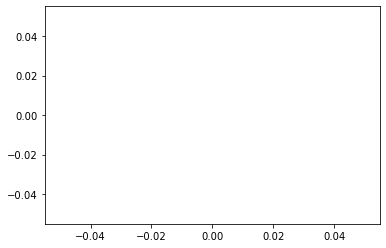

In [10]:
os.chdir('/home/catherinej/test_breach_value/mor_b1_peak')
gauge_solutions = rg(gaugenos='all', outdir='/home/catherinej/test_breach_value/mor_b1_peak/_output')
gaugenos_la = [k for k in gauge_solutions.keys() if gauge_solutions[k].gtype=='lagrangian']
kwargs_plot_point = {'marker':'o','markersize':3,'color':'k'}
particle_tools.plot_particles(gauge_solutions, t=-86400.0, gaugenos=gaugenos_la, kwargs_plot=kwargs_plot_point)

In [37]:
np.max(np.sqrt(p.u**2 + p.v**2))

<xarray.DataArray ()>
array(27.74044205)

-12.0


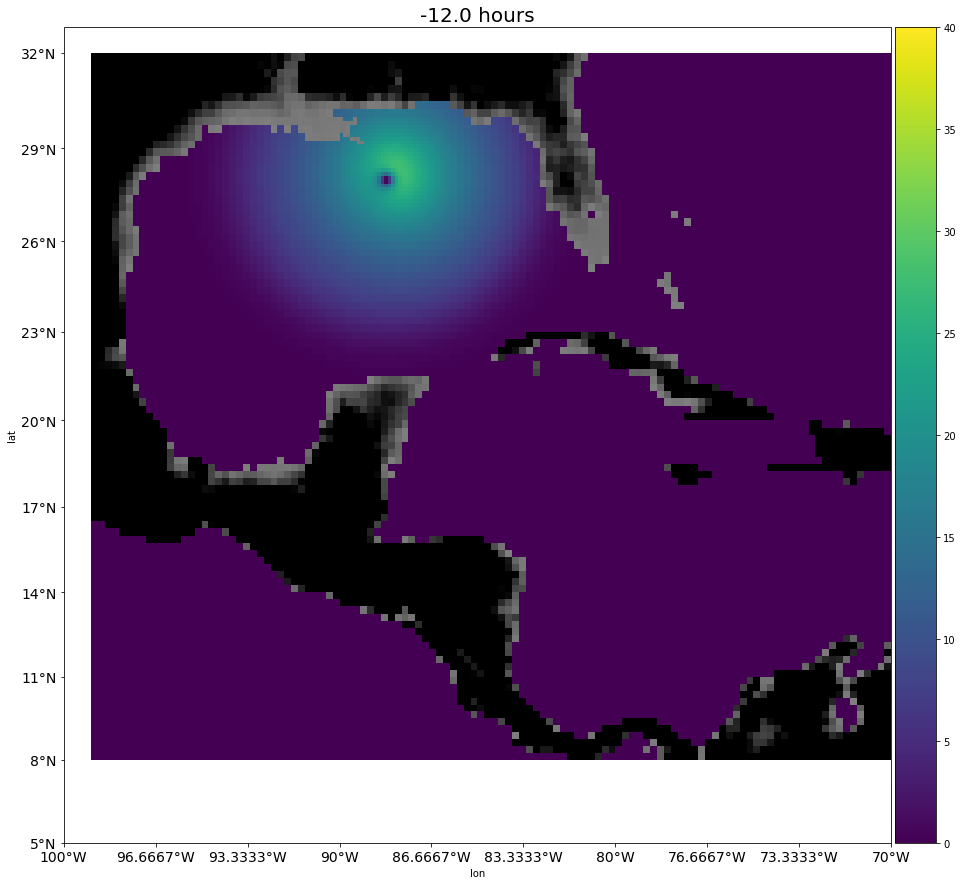

In [40]:
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

proj = ccrs.Mercator()
SOURCE_DIR = '/home/catherinej/test_breach_value/mor_nob'

frames = frame_count(SOURCE_DIR)
cmap = cm.get_cmap('jet', 20)
for fr in range(6,7):
        
    fig, ax = plt.subplots(1,1, figsize=[20,15], subplot_kw=dict(projection=proj))
    img_extent =[-100, -70.0, 5.0, 32.0] # [-73.75, -72.25, 40.50, 41.0] [-73.25, -72.40, 40.60, 40.90] # entire system [-73.75, -72.25, 40.50, 41.0] 
    ax.set_extent(img_extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    path = '/home/catherinej/geoclaw/examples/storm-surge/isaac_syn/'
    patch_dict = read_fortq(fr, os.path.join(path, '_output')) #'/home/catherinej/02102022/mor_b1_early/_output')
    pd = read_fortq(fr, os.path.join(path, '_output')) # '/home/catherinej/02102022/mor_b1_early/_output')
    ds_dict, timestep = organize_patches(patch_dict)
    for amr in ds_dict:
        ds_lst = ds_dict[amr]
        v = np.linspace(-.5, 3.0, 15, endpoint=True)
        for idx, p in enumerate(ds_lst):
            wind_x = p.u
            wind_y = p.v
            wind_speed = np.sqrt(wind_x**2 + wind_y**2)
            wp = p.water
            lp = p.land
            sp = p.speed
            ws = wind_speed.plot.pcolormesh(transform=ccrs.PlateCarree(),add_colorbar=False, vmin=0, vmax=40)
            # wa = sp.plot.pcolormesh(transform=ccrs.PlateCarree(), vmin=-0.5, vmax=4.0, cmap='viridis',add_colorbar=False)
            # sp  = sp.z.plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=speed_cmap, vmin=0.0, vmax=1.0, add_colorbar=False)
            lp.plot.pcolormesh(transform=ccrs.PlateCarree(),cmap='binary', norm=norm_dry, add_colorbar=False)
    kwargs_plot_point = {'marker':'o','markersize':5,'color':'r'}
    print(timestep)
    # pp = particle_tools.interp_particles(gauge_solutions, timestep*3600, gaugenos_la, extend='neither')
    # for k in pp.keys():
    #     print(pp)
    #     x,y = pp[k]
    #     ax.scatter([x],[y], c='r',transform=ccrs.PlateCarree())
    # ax.scatter(-72.765194, 40.763,color='k', transform=ccrs.PlateCarree())
    fig.add_axes(cax)
    plt.colorbar(ws, cax=cax, orientation='vertical') #, ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0])
#     ca.set_ticks([wa.colorbar.vmin + t*(wa.colorbar.vmax-wa.colorbar.vmin) for t in ca.ax.get_yticks()])
    ax.set_title(f'{timestep} hours', fontsize=20)
    ax.set_xticks(np.linspace(img_extent[0], img_extent[1], 10),crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(img_extent[2], img_extent[3], 10), crs=ccrs.PlateCarree())
    lon_formatter = cartopy.mpl.ticker.LongitudeFormatter()
    lat_foramtter = cartopy.mpl.ticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_foramtter)
    ax.tick_params(axis='both',labelsize=14)
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
#     gl.top_labels = False
#     gl.left_labels = True
#     gl.right_labels = False
#     gl.bottom_labels = True
#     gl.xlines = True
#     gl.xlocator = mticker.FixedLocator(np.linspace(img_extent[0], img_extent[1], 5))#[120, 140, 160, 180, -160, -140, -120])
#     gl.ylocator = mticker.FixedLocator(np.linspace(img_extent[2], img_extent[3], 10))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    plt.savefig(f'breach_peak{fr:03}.png',dpi=250,bbox_inches = 'tight', pad_inches = 0) 
#     plt.close()

51.0


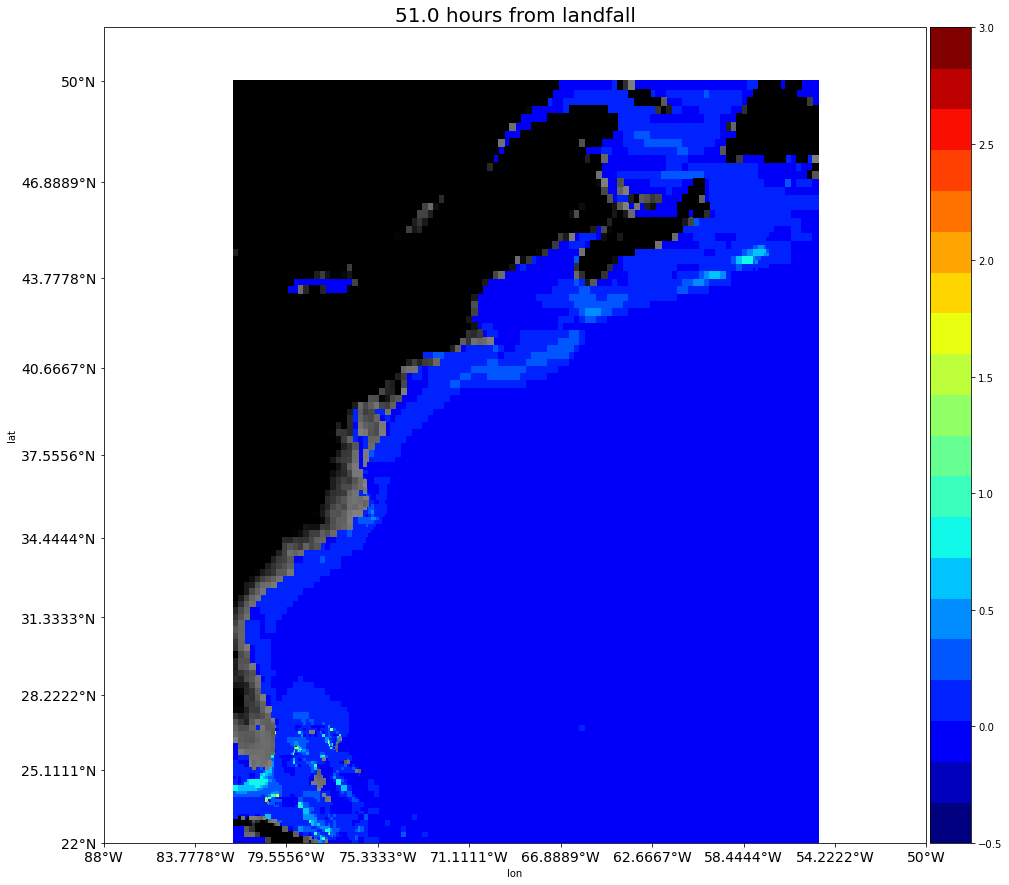

In [28]:
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

proj = ccrs.Mercator()
SOURCE_DIR = '/home/catherinej/sims/synthetic_owi_larger'

frames = frame_count(SOURCE_DIR)
cmap = cm.get_cmap('jet', 20)
for fr in range(51,52):
        
    fig, ax = plt.subplots(1,1, figsize=[20,15], subplot_kw=dict(projection=proj))
    img_extent =[-88.0, -50.0, 22.0, 50.0] # [-73.75, -72.25, 40.50, 41.0] [-73.25, -72.40, 40.60, 40.90] # entire system [-73.75, -72.25, 40.50, 41.0] 
    ax.set_extent(img_extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)

    patch_dict = read_fortq(fr, '/home/catherinej/sims/synthetic_owi_larger/_output')
    pd = read_fortq(fr, '/home/catherinej/sims/synthetic_owi_larger/_output')
    ds_dict, timestep = organize_patches(patch_dict)
    for amr in ds_dict:
        ds_lst = ds_dict[amr]
        v = np.linspace(-.5, 3.0, 15, endpoint=True)
        for idx, p in enumerate(ds_lst):
            wp = p.water
            lp = p.land
            sp = p.speed

            wa = sp.plot.pcolormesh(transform=ccrs.PlateCarree(), vmin=-0.5, vmax=3.0, cmap=cmap,add_colorbar=False)
#             sp  = sp.z.plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=speed_cmap, vmin=0.0, vmax=1.0, add_colorbar=False)
            lp.plot.pcolormesh(transform=ccrs.PlateCarree(),cmap='gist_yarg', norm=norm, add_colorbar=False)
    kwargs_plot_point = {'marker':'o','markersize':5,'color':'r'}
    print(timestep)
    # pp = particle_tools.interp_particles(gauge_solutions, timestep, gaugenos_la, extend='neither')
#     for k in pp.keys():
#         x,y = pp[k]
#         ax.scatter([x],[y], c='r',transform=ccrs.PlateCarree())
    
    fig.add_axes(cax)
    plt.colorbar(wa, cax=cax, orientation='vertical') #, ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0])
#     ca.set_ticks([wa.colorbar.vmin + t*(wa.colorbar.vmax-wa.colorbar.vmin) for t in ca.ax.get_yticks()])
    ax.set_title(f'{timestep} hours from landfall', fontsize=20)
    ax.set_xticks(np.linspace(img_extent[0], img_extent[1], 10),crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(img_extent[2], img_extent[3], 10), crs=ccrs.PlateCarree())
    lon_formatter = cartopy.mpl.ticker.LongitudeFormatter()
    lat_foramtter = cartopy.mpl.ticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_foramtter)
    ax.tick_params(axis='both',labelsize=14)
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
#     gl.top_labels = False
#     gl.left_labels = True
#     gl.right_labels = False
#     gl.bottom_labels = True
#     gl.xlines = True
#     gl.xlocator = mticker.FixedLocator(np.linspace(img_extent[0], img_extent[1], 5))#[120, 140, 160, 180, -160, -140, -120])
#     gl.ylocator = mticker.FixedLocator(np.linspace(img_extent[2], img_extent[3], 10))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    # plt.savefig(os.path.join('/Users/catherinej/RData/VT/gauss/',f'no_breach_{fr:03}.png'),dpi=250,bbox_inches = 'tight',
    # pad_inches = 0) 
#     plt.close()

In [35]:
pp = particle_tools.interp_particles(gauge_solutions, 1*3600, gaugenos_la, extend='neither')
pp

{1: (-72.76515, 40.76007), 2: (-72.76515, 40.76308), 3: (-72.76515, 40.76713)}

8
9
10
11
12
13
14
15


NameError: name 'organize_patch_data' is not defined

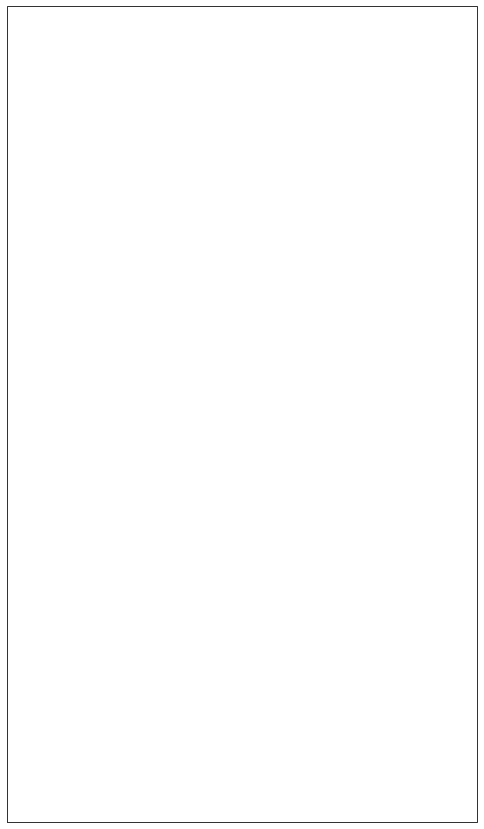

In [8]:
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

proj = ccrs.Mercator()
SOURCE_DIR = '/Users/catherinej/RData/VT/gauss/mor/'

frames = frame_count(SOURCE_DIR)

for fr in range(1,2):
        
    fig, ax = plt.subplots(1,1, figsize=[20,15], subplot_kw=dict(projection=proj))
    img_extent = [-75.0, -72., 38.00, 42.0] # just shinnecock[-72.65, -72.40, 40.79, 40.87] #[-73.25, -72.40, 40.60, 40.90] # entire system [-73.75, -72.25, 40.50, 41.0] 
    ax.set_extent(img_extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)

    patch_dict = read_fortq(fr, '/Users/catherinej/RData/VT/gauss/mor/_output')

    daw, dal, das, ds_wind, timestep = organize_patch_data(patch_dict)
    for amr in daw:

        land_dest = f'land_{amr}'
        water_dest = f'water_{amr}'
        speed_dest = f'speed_{amr}'
        slst = das[amr]
        wlst = daw[amr]
        llst = dal[amr]
        wind = ds_wind[amr]
       
        for idx, p in enumerate(wlst):
            wp = p
            lp = llst[idx]
            sp = slst[idx]
            wi = wind[idx]
            
            wa = wp.z.plot.pcolormesh(transform=ccrs.PlateCarree(),vmin=0.33, vmax=3.0, add_colorbar=False, cmap='jet')
#             sp  = sp.z.plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=speed_cmap, vmin=0.0, vmax=1.0, add_colorbar=False)
            lp.z.plot.pcolormesh(transform=ccrs.PlateCarree(),cmap='binary',norm=norm, add_colorbar=False)
            if (amr >= 4):
                y = wi.lat.values
                x = wi.lon.values
                X, Y = np.meshgrid(x,y)
#                 print(X.shape, Y.shape, wi.v.values.shape, wi.u.values.shape)
                ax.quiver(X, Y, u=wi.u.values, v=wi.v.values, color='r', units='width',regrid_shape=20, transform=ccrs.PlateCarree())
    kwargs_plot_point = {'marker':'o','markersize':5,'color':'r'}
    print(timestep)
    pp = particle_tools.interp_particles(gauge_solutions, timestep, gaugenos_la, extend='neither')
    for k in pp.keys():
        x,y = pp[k]
        ax.scatter([x],[y], c='r',transform=ccrs.PlateCarree())
    fig.add_axes(cax)
    plt.colorbar(wa, cax=cax, orientation='vertical')
    ax.set_title(f'{timestep} hours from landfall')
    ax.set_xticks(np.linspace(img_extent[0], img_extent[1], 10),crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(img_extent[2], img_extent[3], 10), crs=ccrs.PlateCarree())
    lon_formatter = cartopy.mpl.ticker.LongitudeFormatter()
    lat_foramtter = cartopy.mpl.ticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_foramtter)
#     plt.savefig(f'vectors_{fr:03}.png')
#     plt.close()

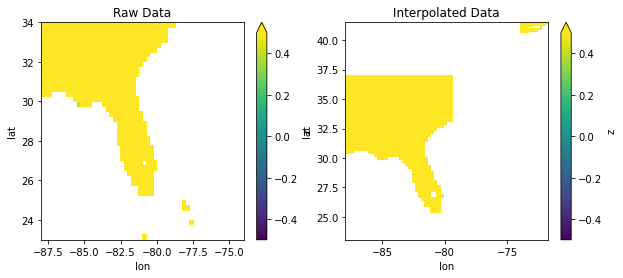

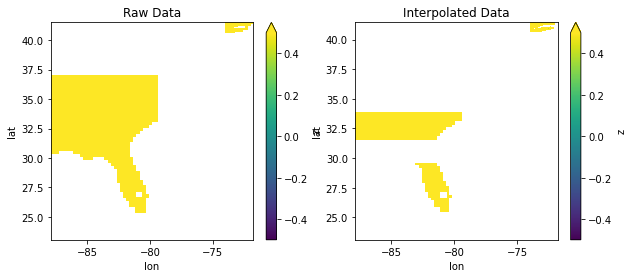

In [64]:
p = [ da2l, da3l]#, da3w, da4w, da5w, da6w]
for i, pp in enumerate(p):
    if i == 0:
        d = da1l
        δ_0 = d.delta[0]
    
    ds = xr.merge(pp)
    δ_1 = ds.delta[0]
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    d.z.plot(ax=axes[0],vmin=-0.5, vmax=0.5)
    axes[0].set_title('Raw Data')
    res = δ_0/δ_1
    new_lon = np.linspace(d.lon[0], d.lon[-1], int(res*len(d.lon)))
    new_lat = np.linspace(d.lat[0], d.lat[-1], int(len(d.lat)*res))
    d = d.drop('delta')
    ds = ds.drop('delta')
    ds_interp = d.interp(lat=new_lat, lon=new_lon)
    ds_m = xr.merge([ds, ds_interp], compat='no_conflicts')
    ds_m = ds_m.fillna(ds_interp)
    ds_m.z.plot(ax=axes[1],vmin=-0.5, vmax=0.5)
    axes[1].set_title('Interpolated Data')
    d = ds_m
    ds_m['delta'] = δ_0

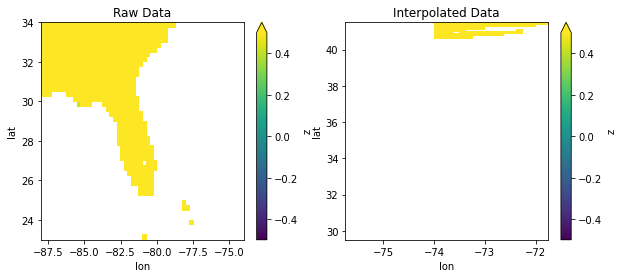

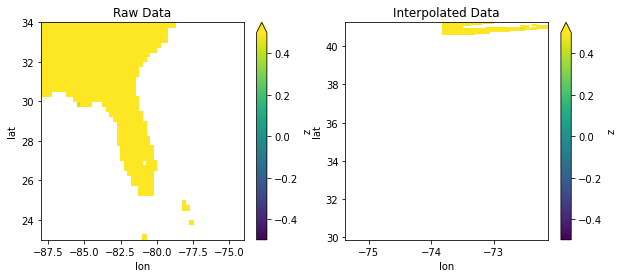

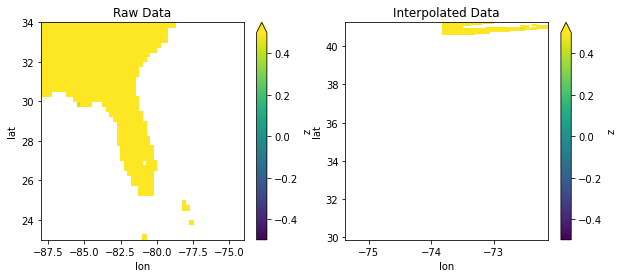

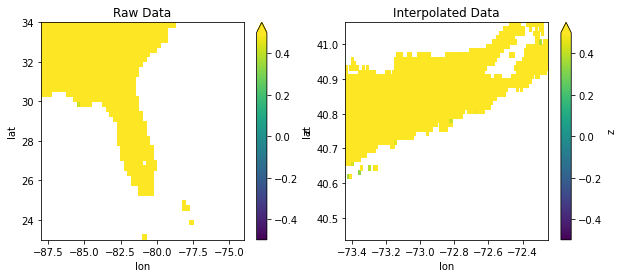

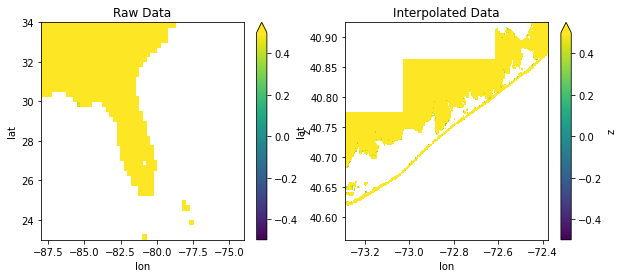

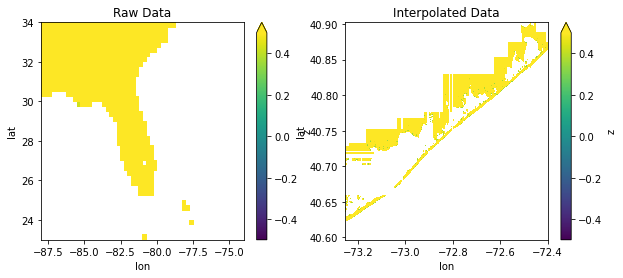

In [78]:
p = [ da2l, da3l, da3l, da4l, da5l, da6l]
for i, pp in enumerate(p):
    if i == 0:
        d = da1l
    ds = xr.merge(pp)
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    d.z.plot(ax=axes[0],vmin=-0.5, vmax=0.5)
    axes[0].set_title('Raw Data')
    ds_interp = d.interp(lat=ds['lat'], lon=ds['lon'])
    ds_m = xr.merge([ds, ds_interp], compat='override')
    ds_m = ds_m.fillna(ds_interp)
    ds_m.z.plot(ax=axes[1],vmin=-0.5, vmax=0.5)
    axes[1].set_title('Interpolated Data')
    dl = ds_m

In [40]:
from colormap_fun import gmtColormap

Populating the interactive namespace from numpy and matplotlib


/Users/catherinej/.pyenv/versions/3.6.3/envs/claw-3.6.3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [41]:
colors = gmtColormap('wiki-france', '/Users/catherinej/projects/map_making/gmt/cpt')
my_cmap = matplotlib.colors.LinearSegmentedColormap('wiki_france', colors)
water_colors = gmtColormap('wiki-water', '/Users/catherinej/projects/map_making/gmt/cpt')
water_cmap = matplotlib.colors.LinearSegmentedColormap('wiki-water', water_colors)

In [36]:
from clawpack.visclaw import colormaps, plottools
zmin = -60.
zmax = 40.

land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)
                                     
sea_cmap_dry = colormaps.make_colormap({ 0.0:[1.0,0.7,0.7], 1.:[1.0,0.7,0.7]})
cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, sea_cmap_dry),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)

In [22]:
from clawpack.visclaw import gridtools
frameno = 37
framesoln = Solution(frameno, path='/Users/catherinej/RData/VT/gauss/mor_10hrs/_output',
                    file_format='binary')

In [77]:
eta = lambda q: q[3,:,:]
B = lambda q: q[3,:,:] - q[0,:,:]
out_var = lambda q: np.array((B(q), eta(q)))

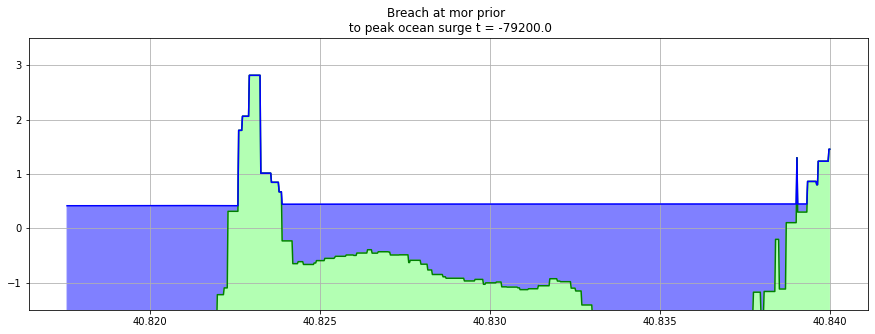

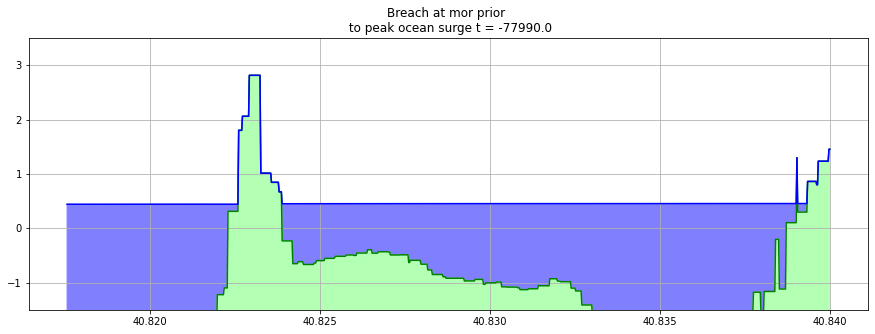

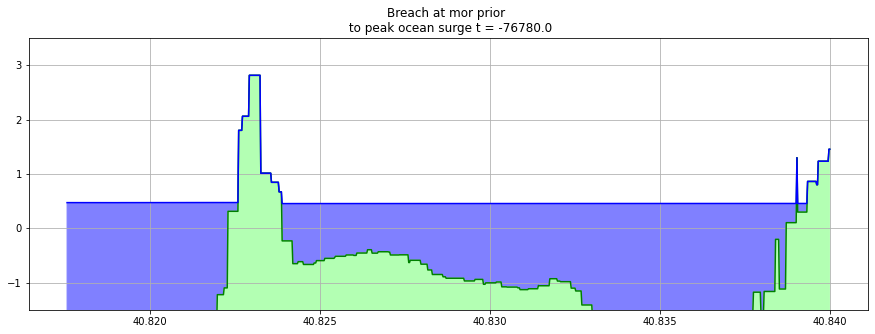

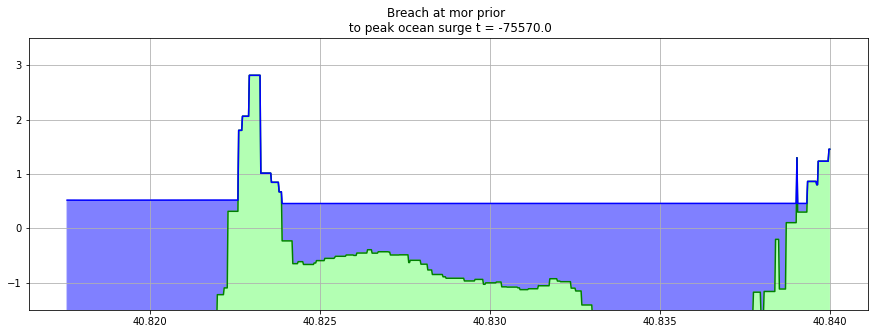

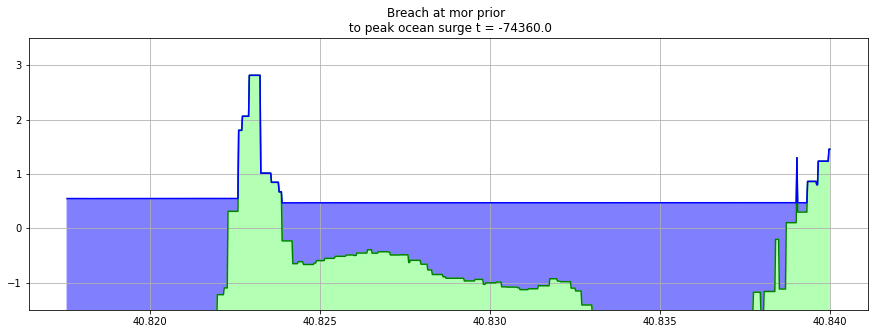

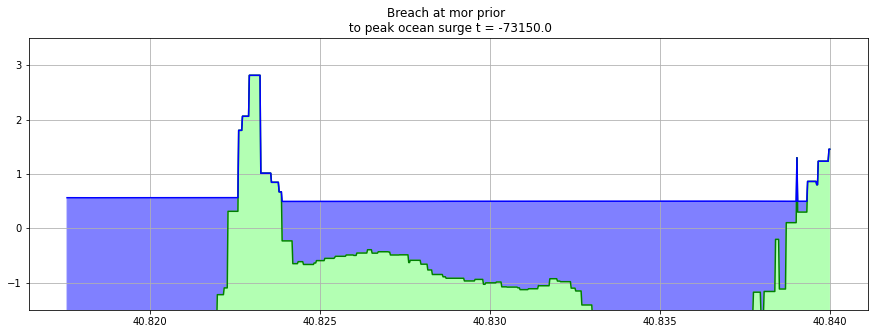

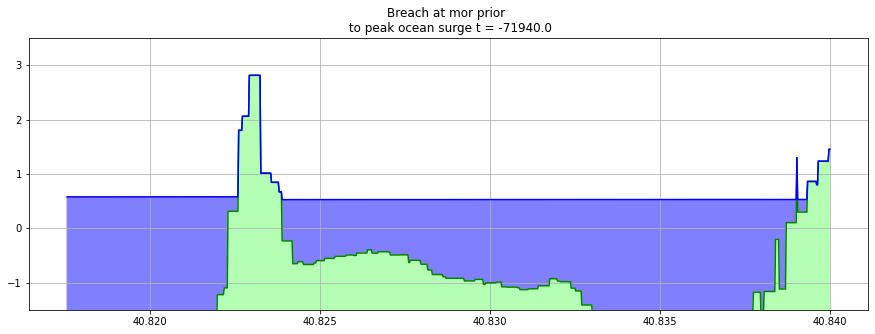

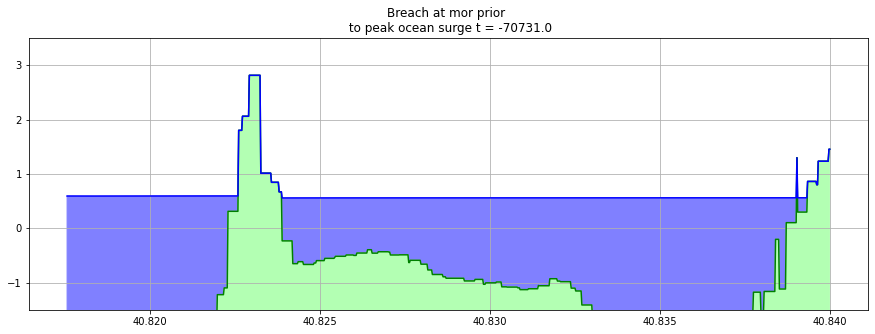

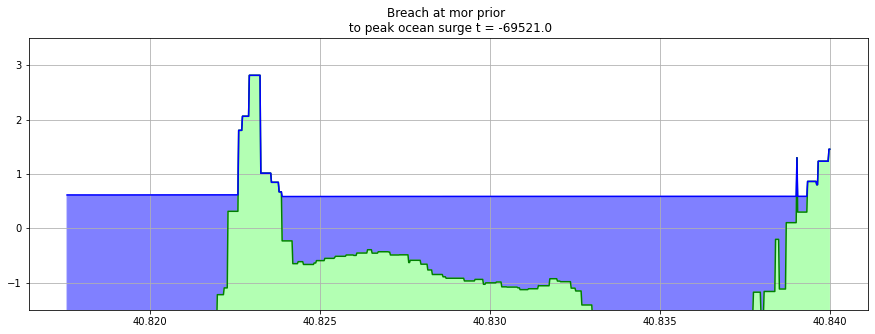

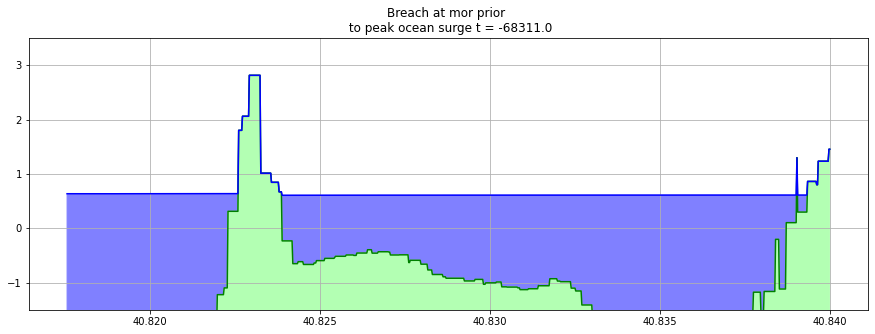

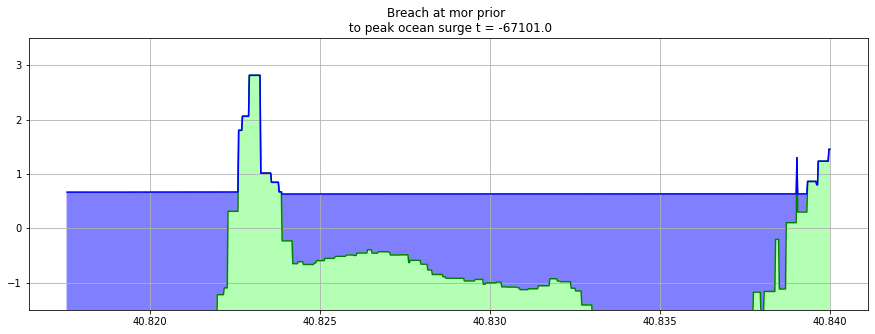

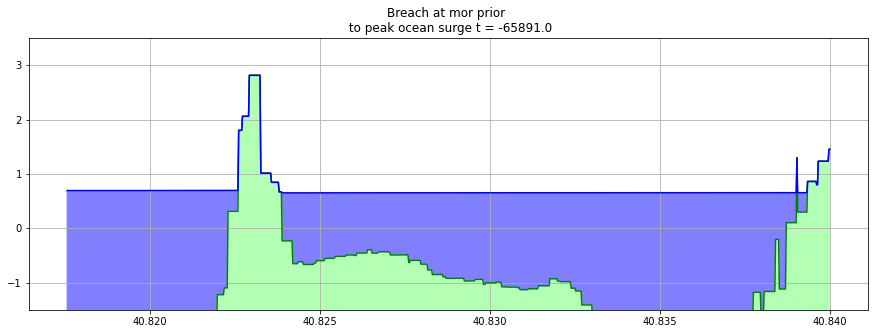

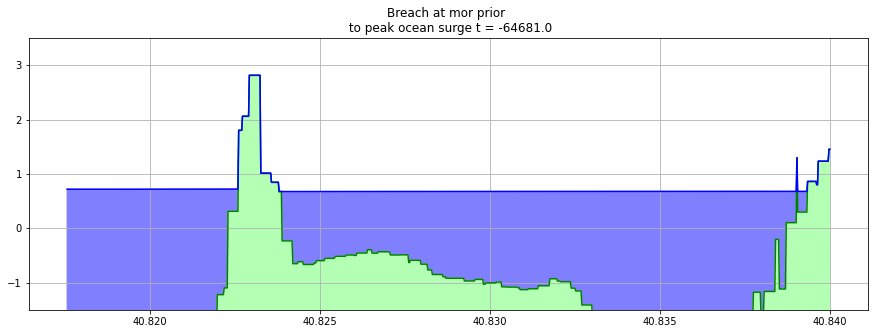

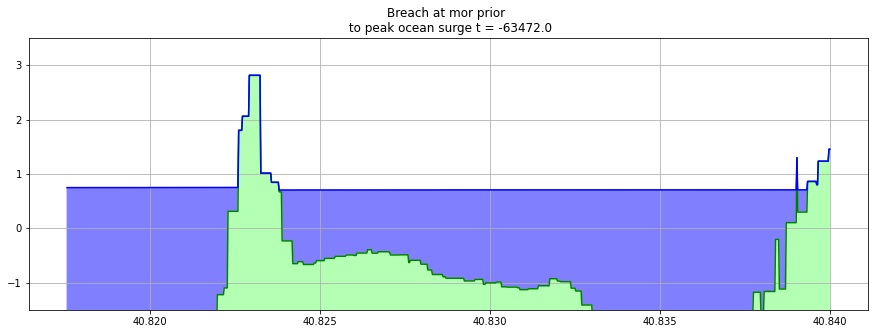

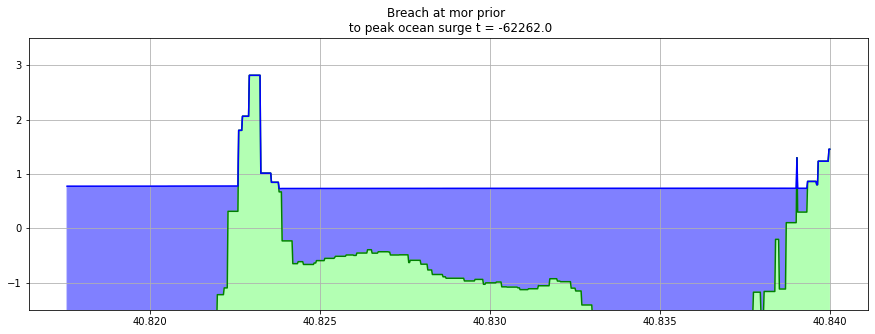

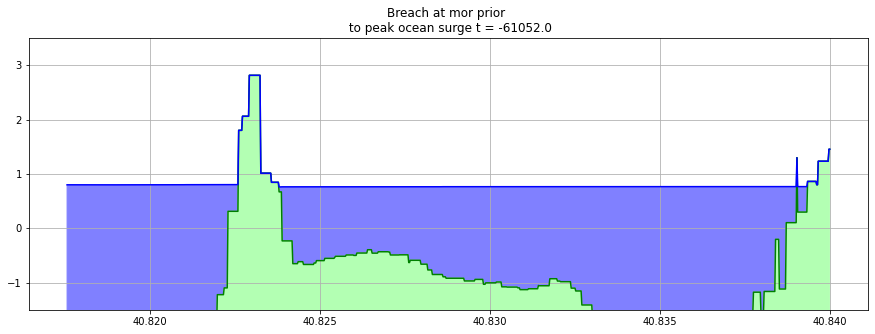

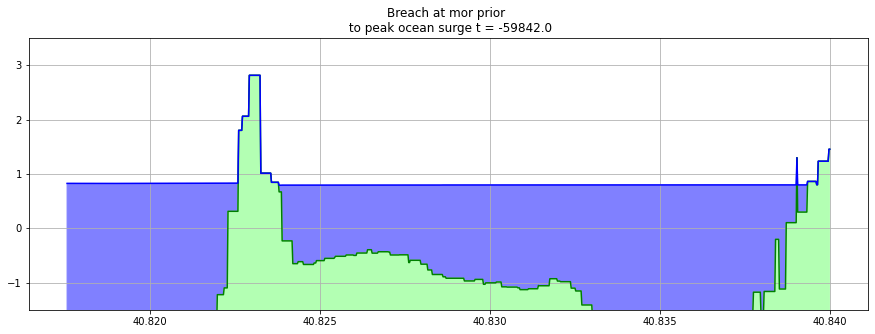

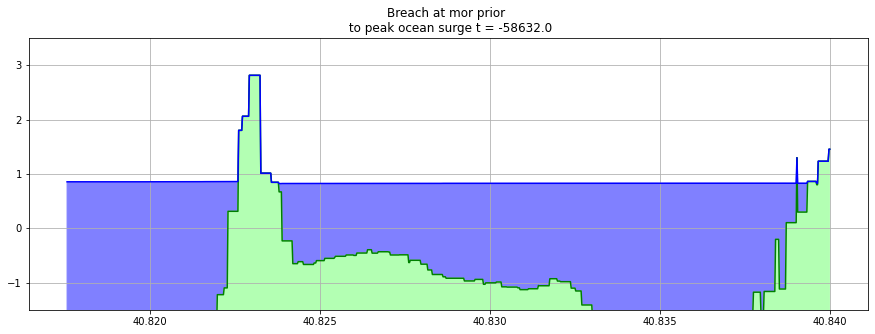

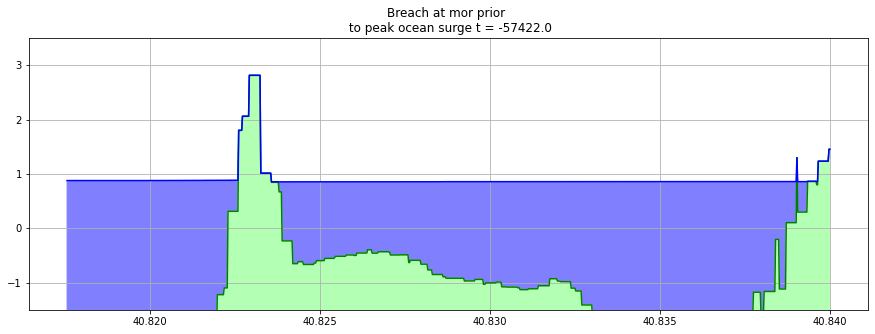

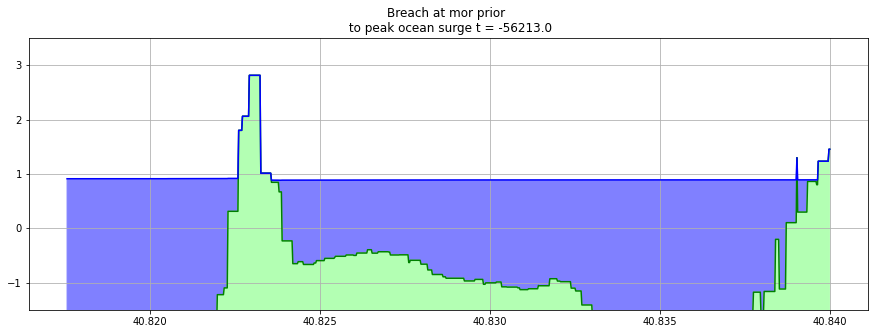

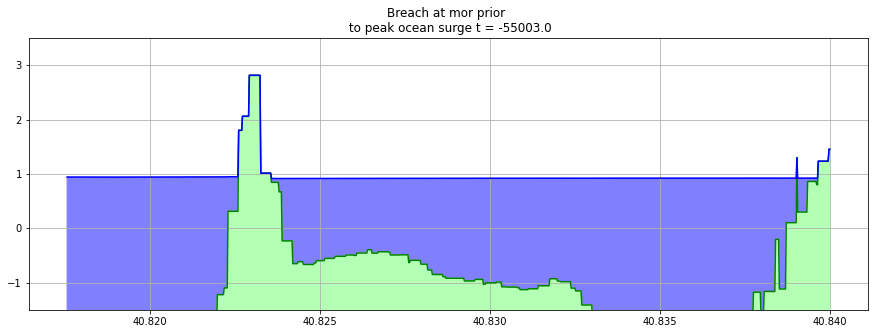

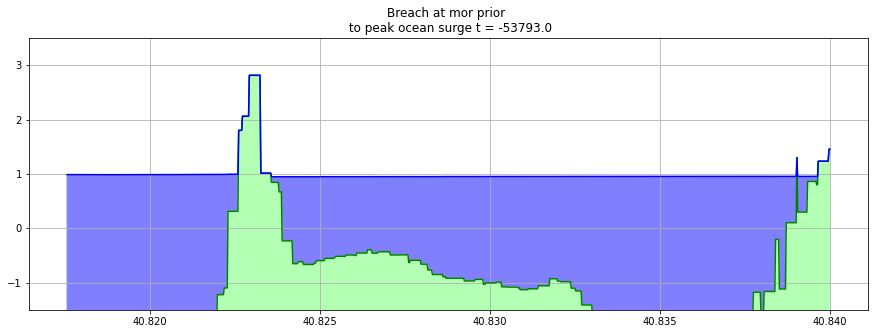

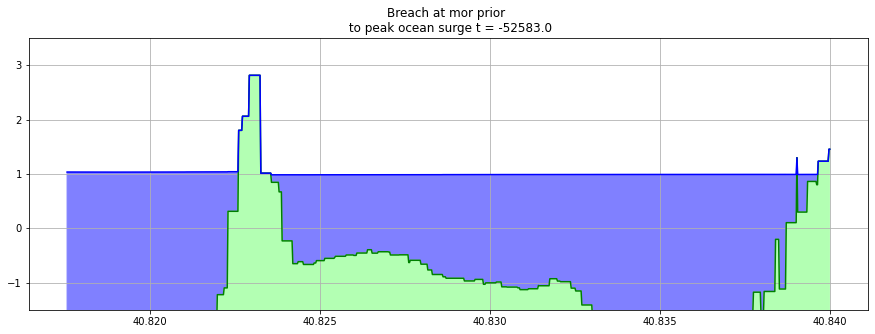

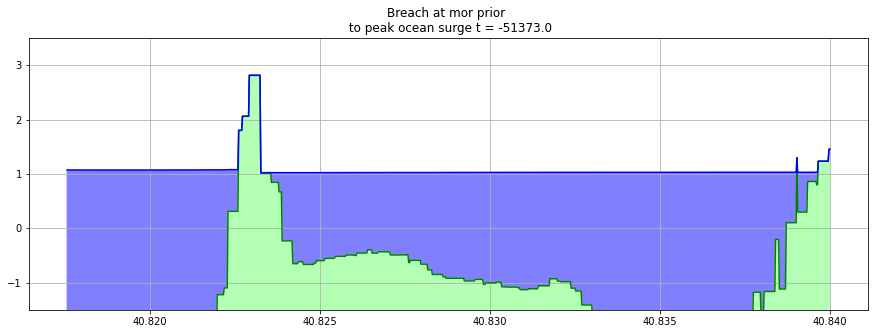

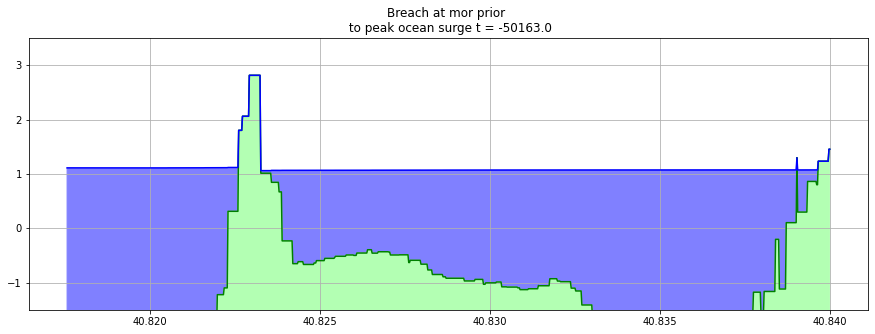

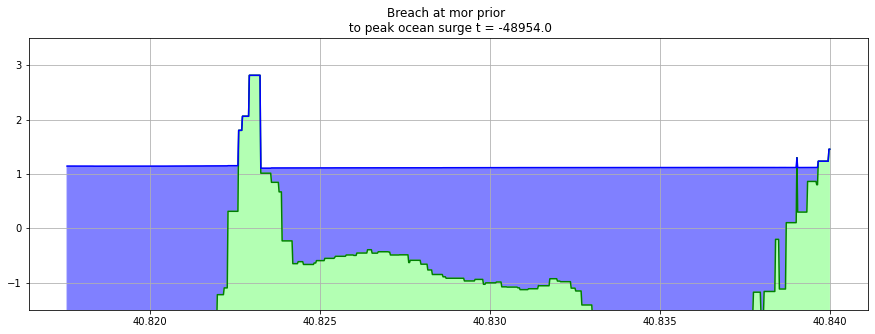

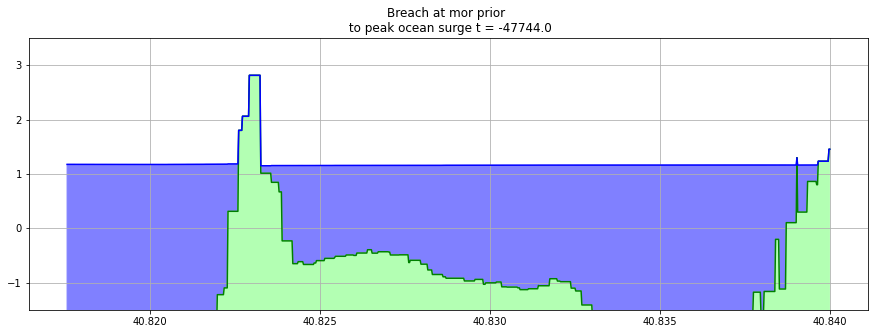

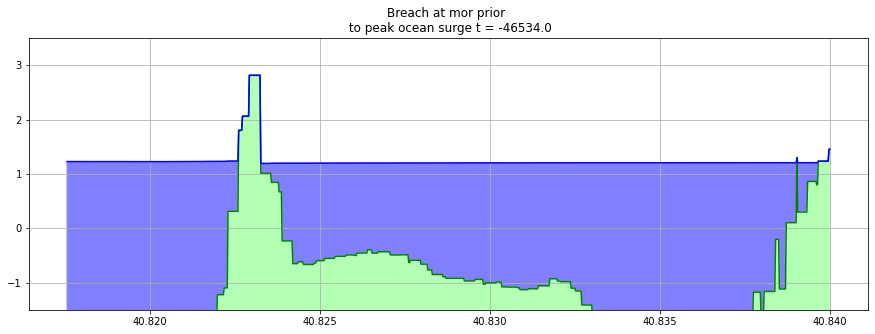

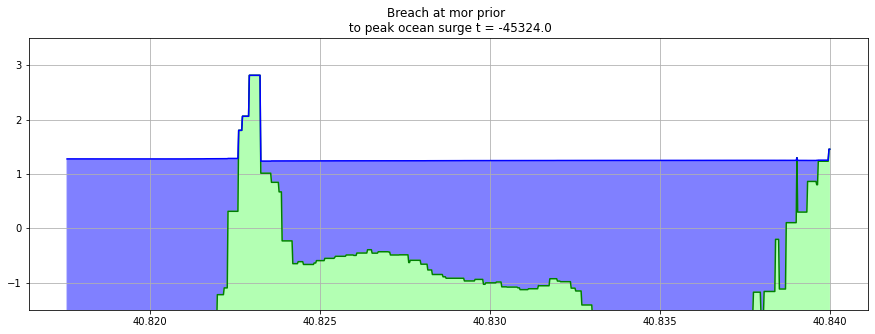

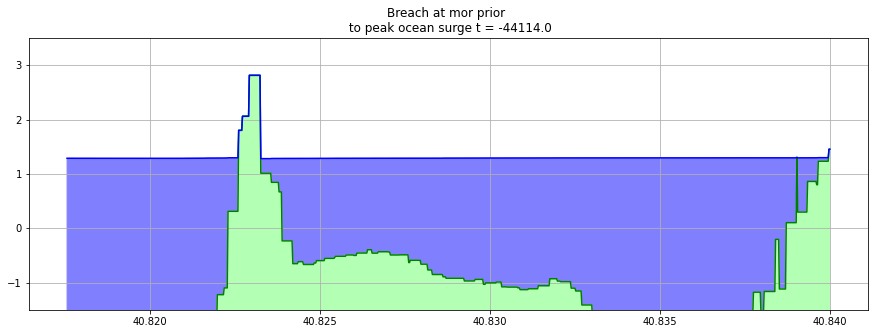

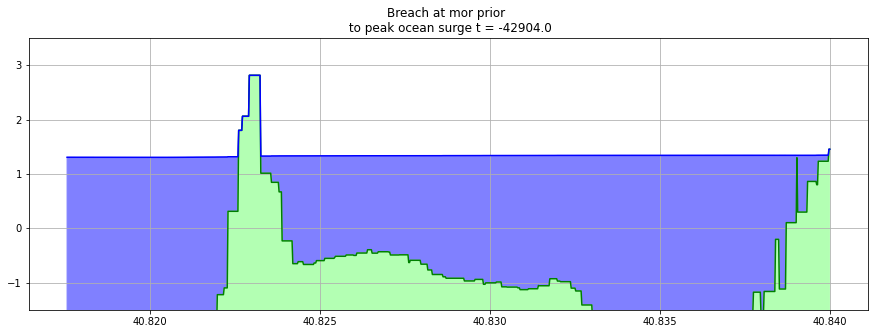

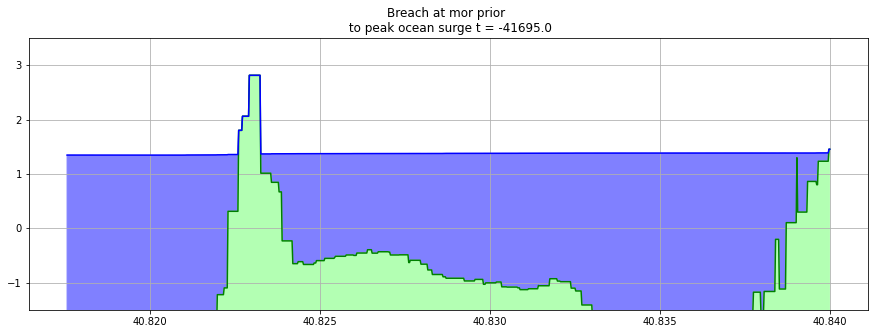

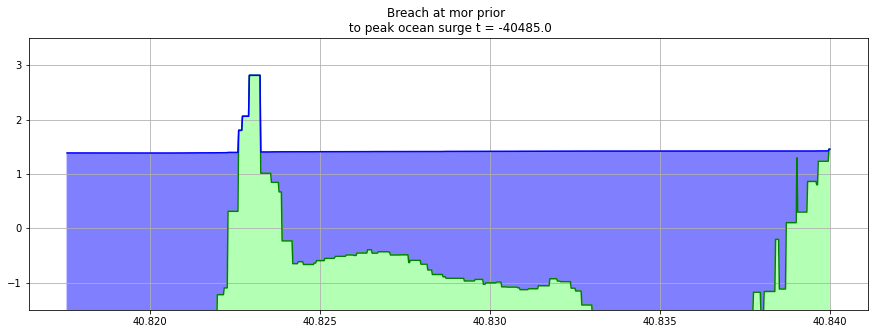

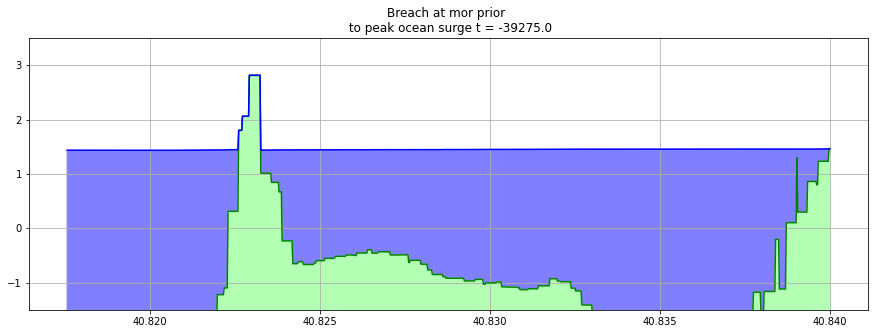

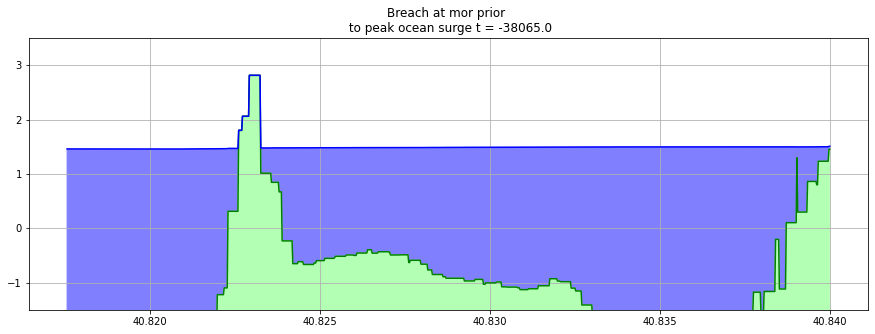

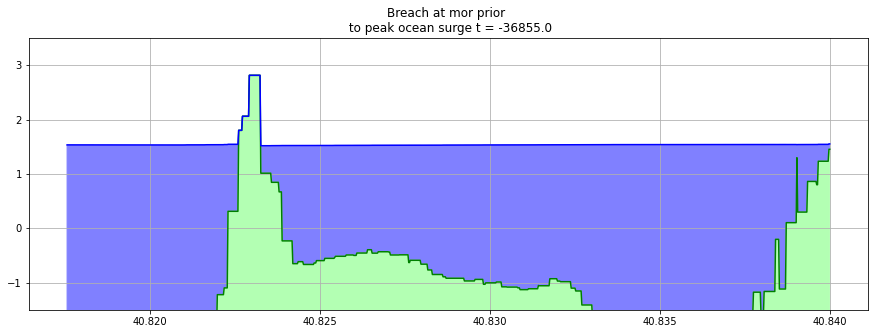

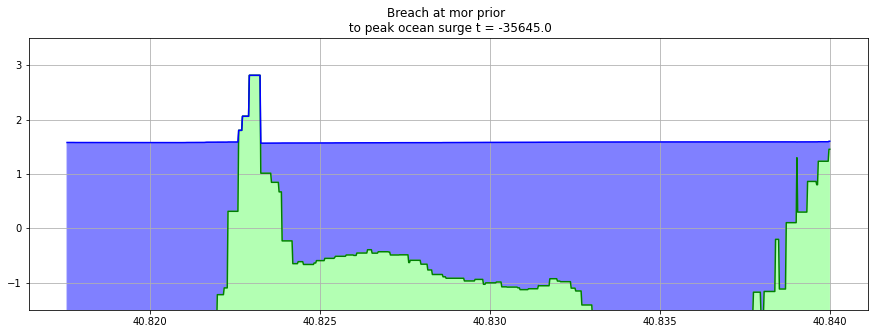

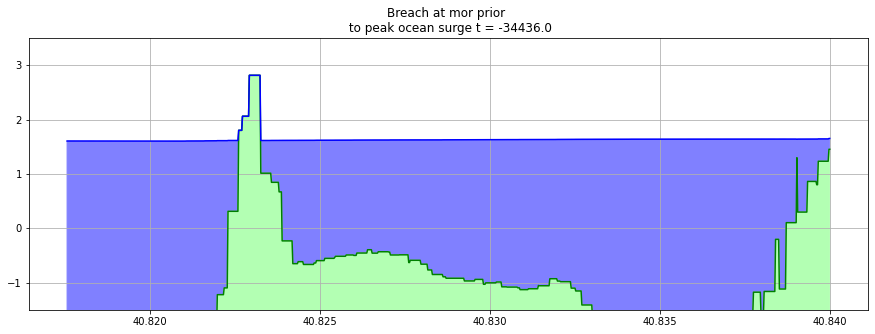

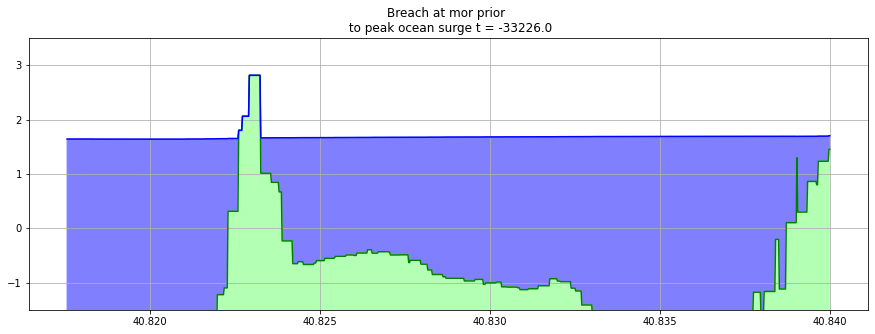

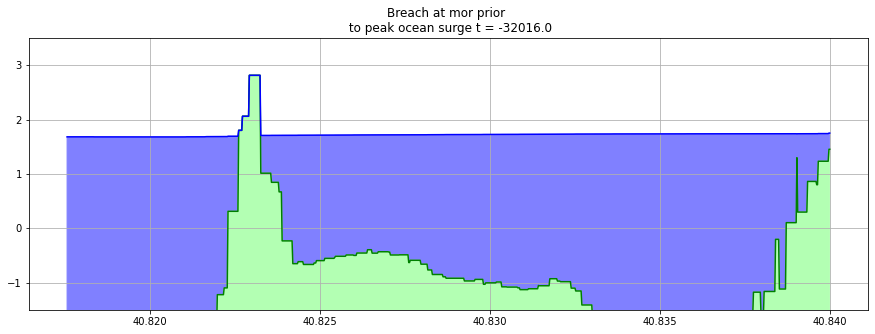

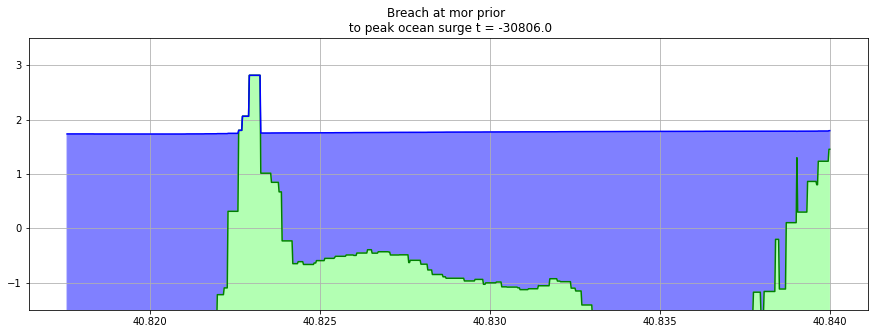

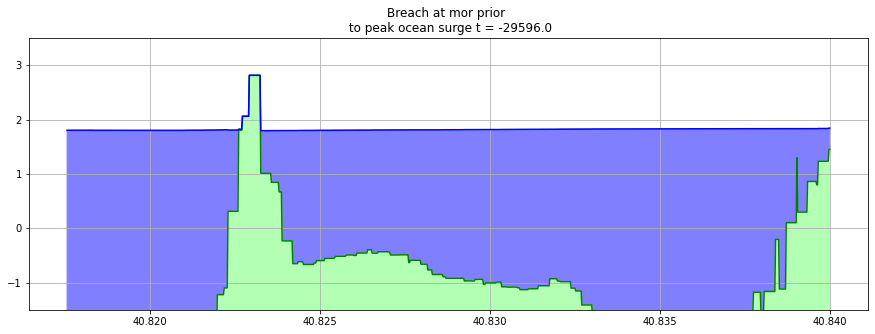

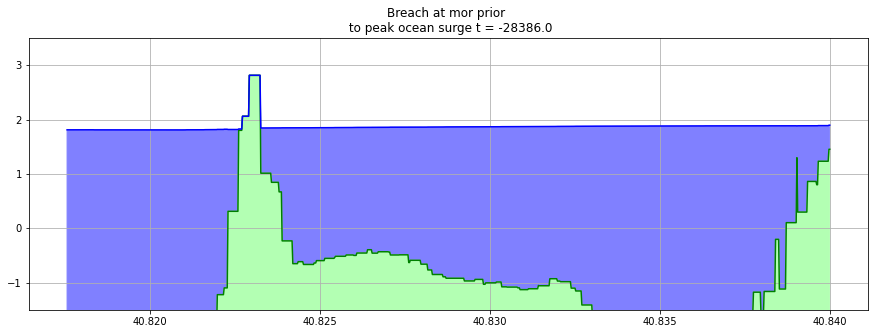

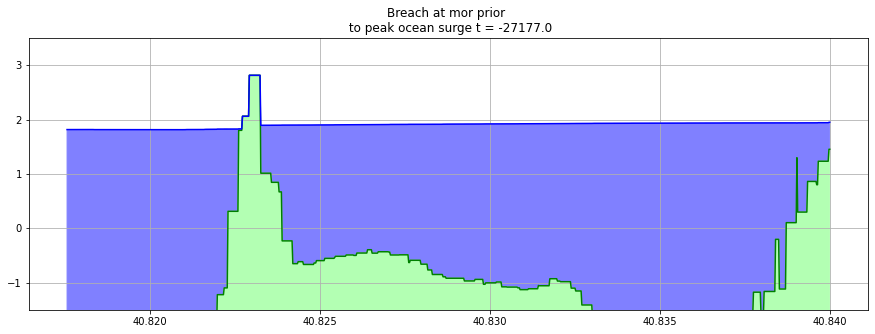

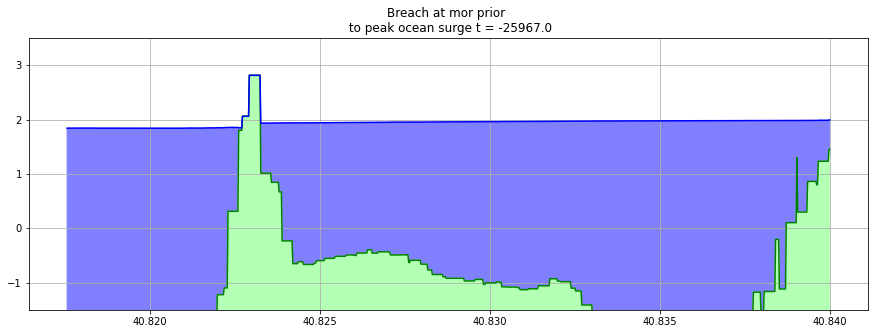

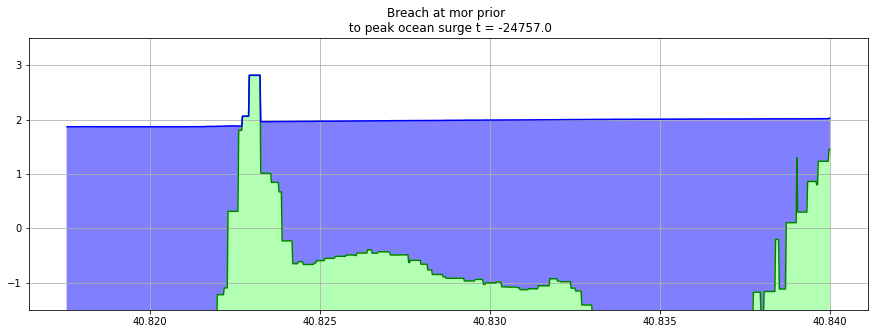

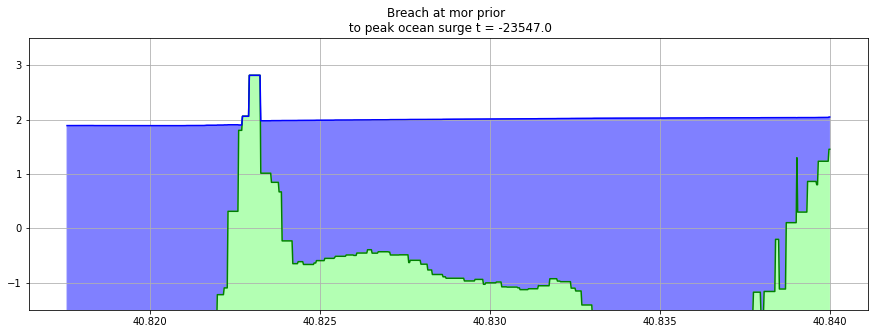

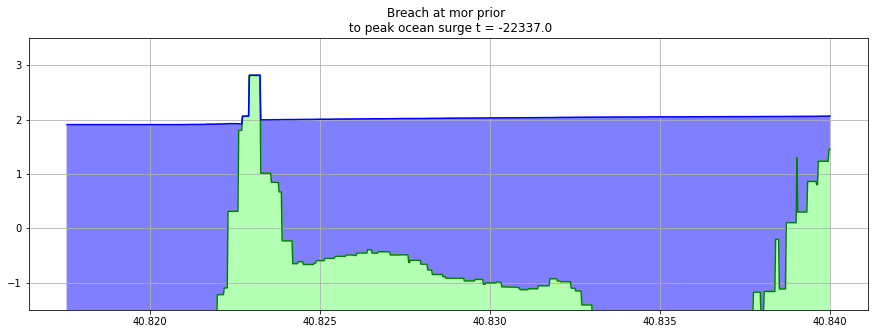

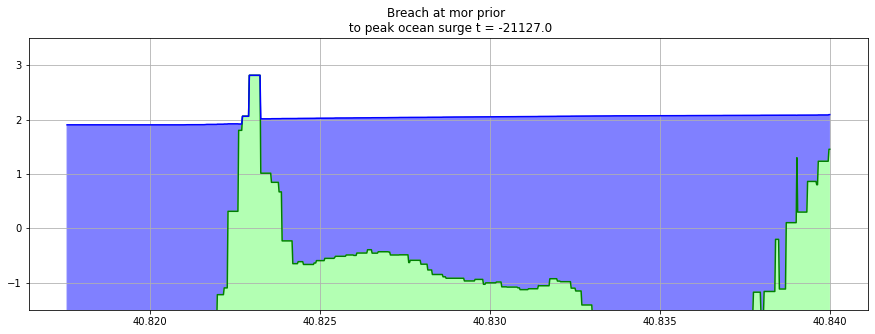

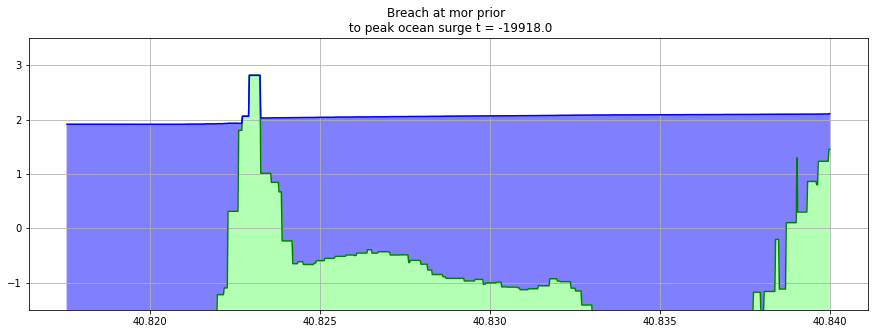

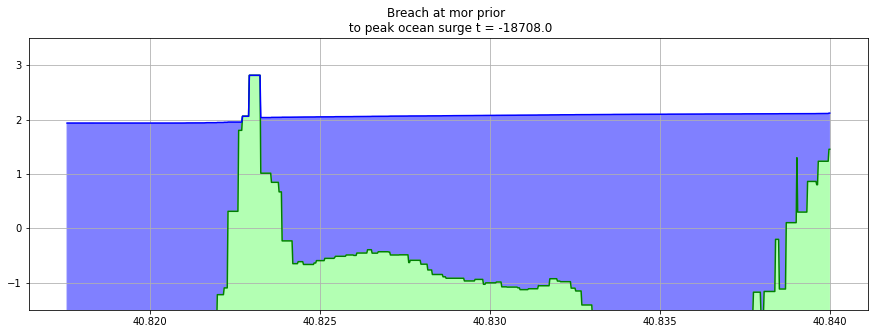

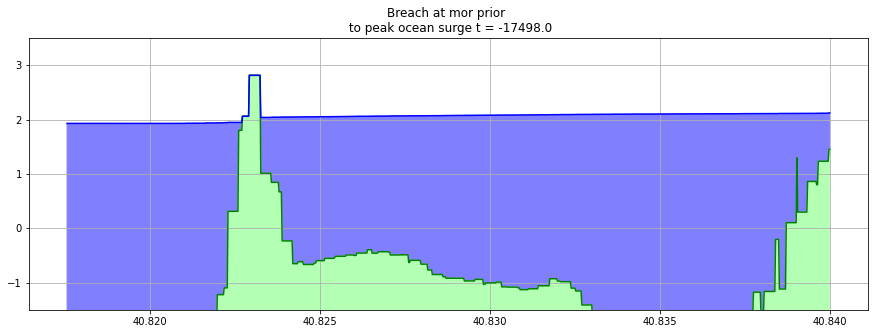

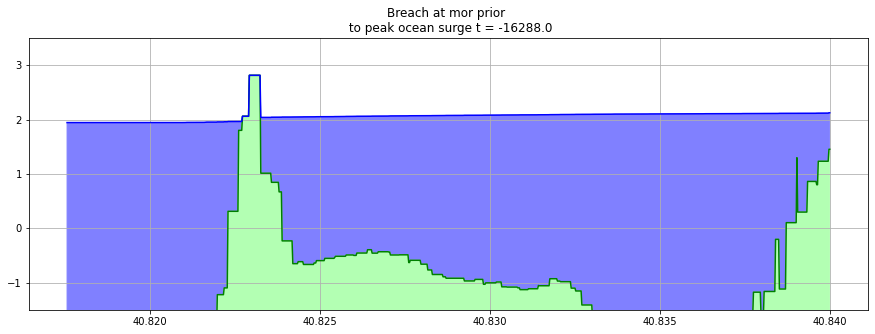

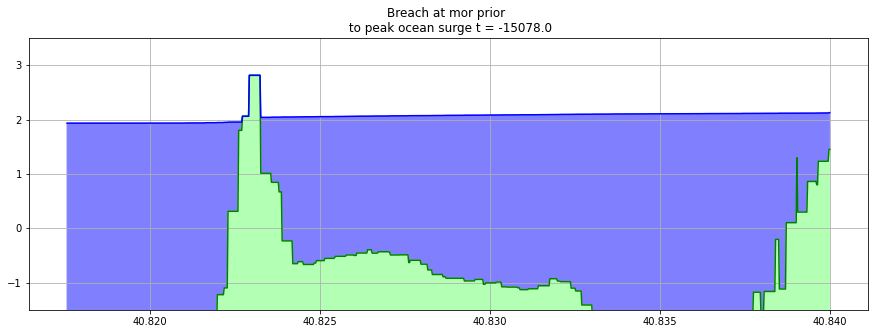

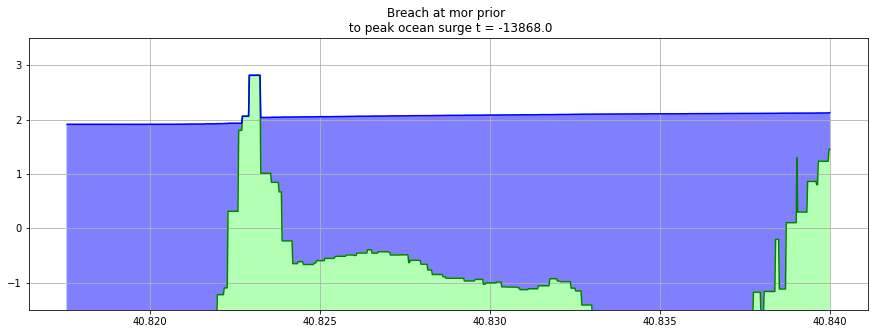

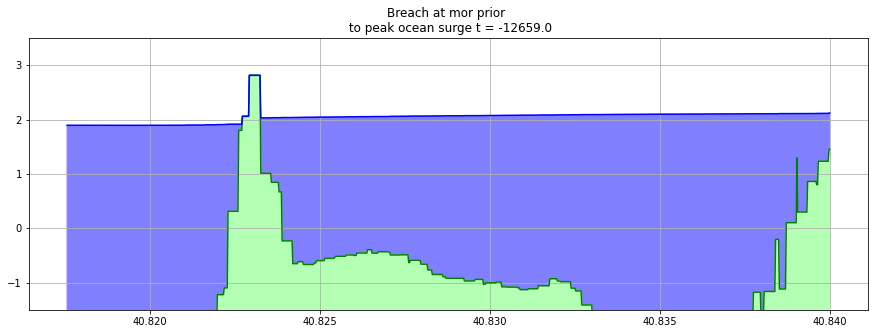

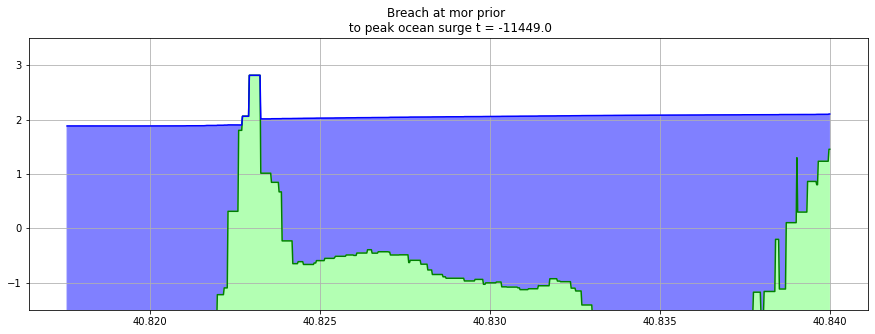

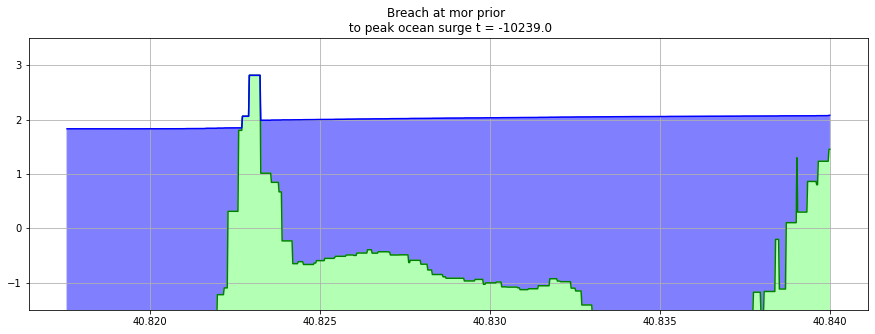

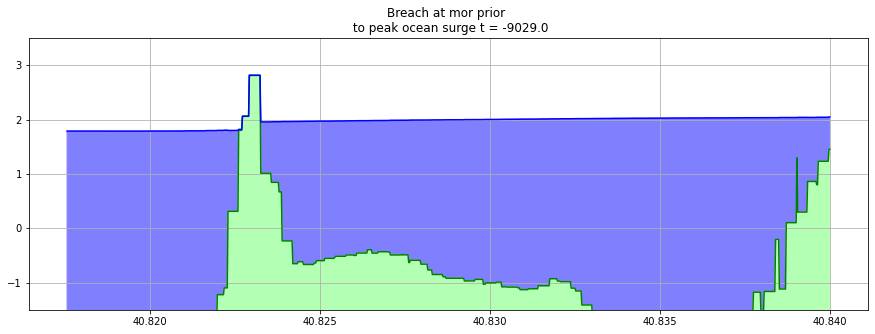

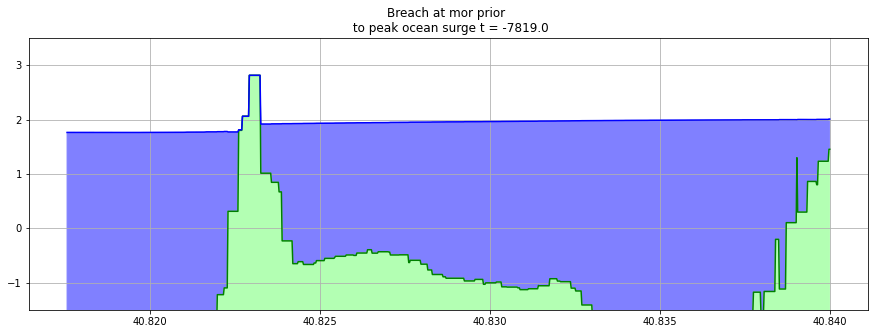

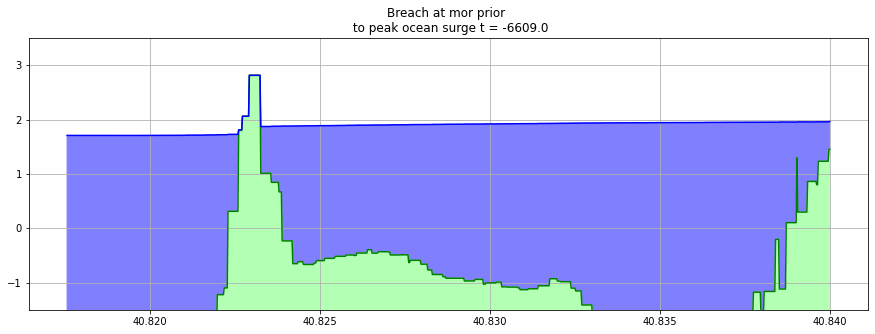

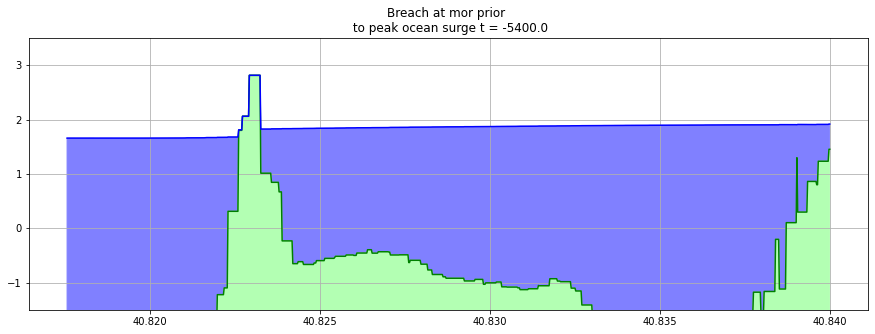

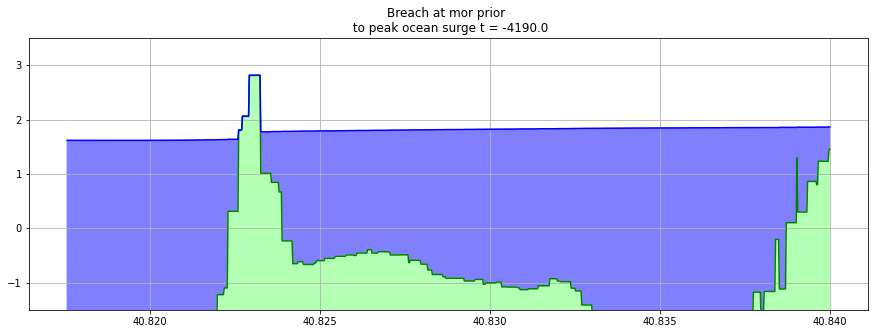

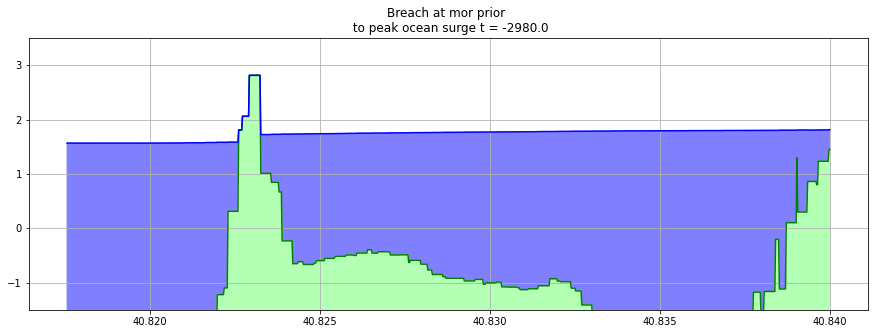

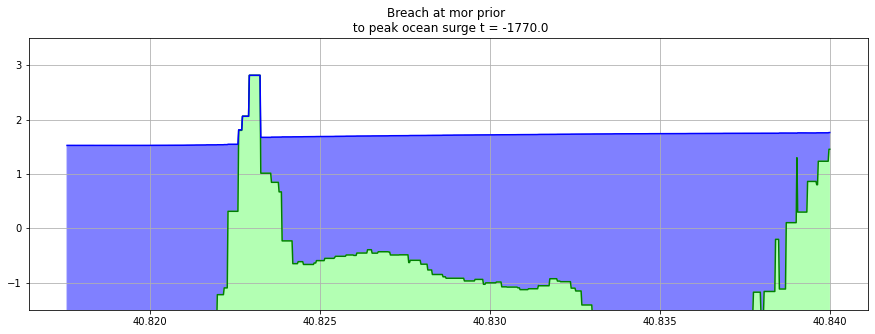

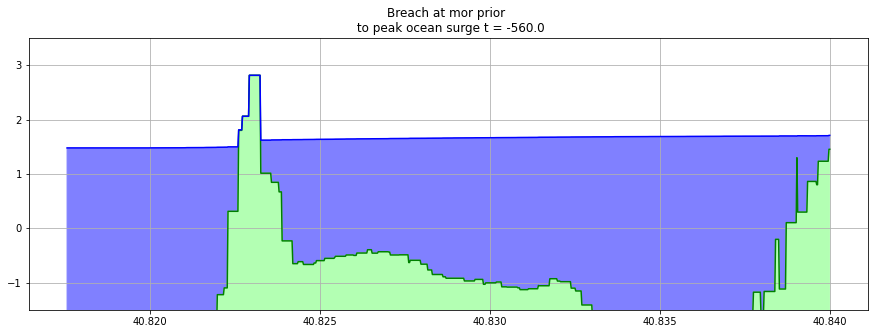

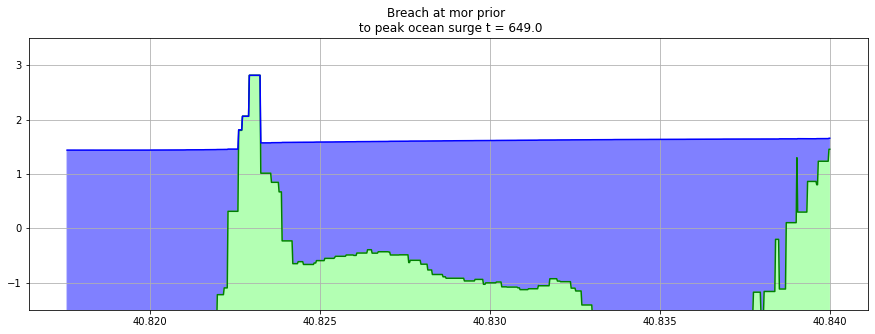

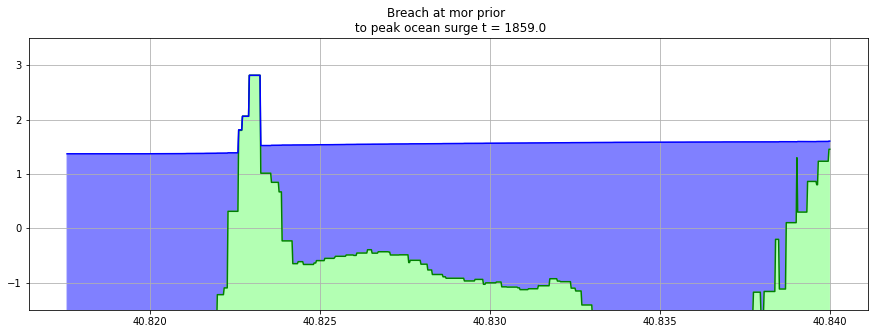

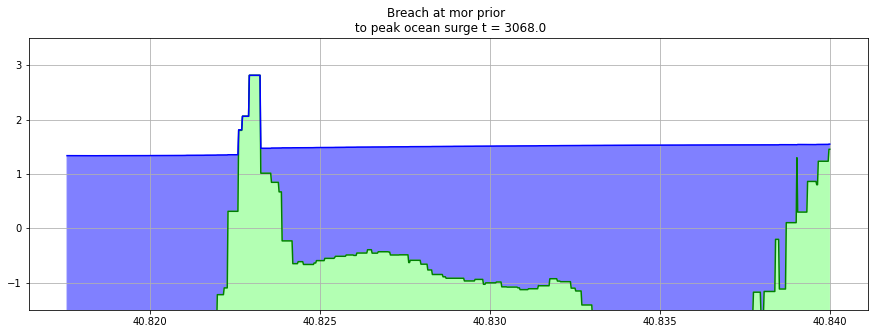

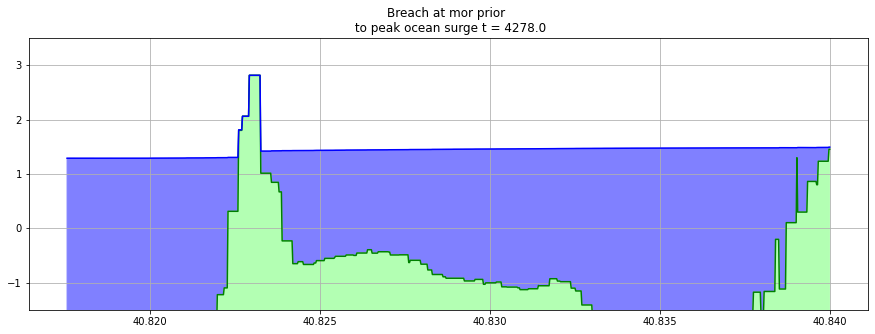

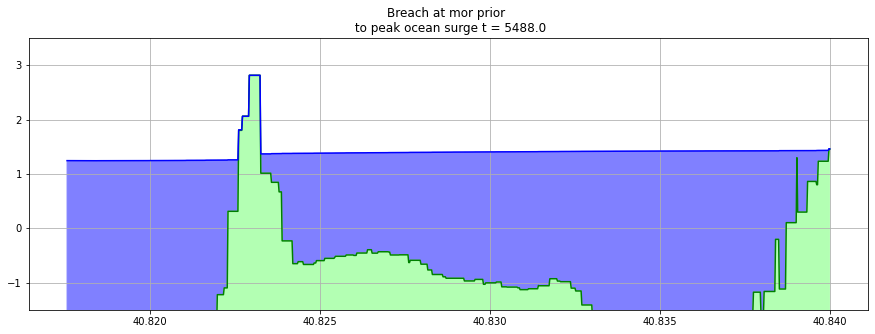

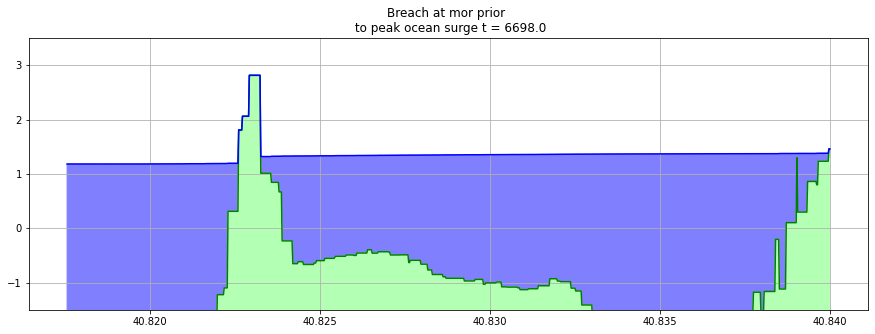

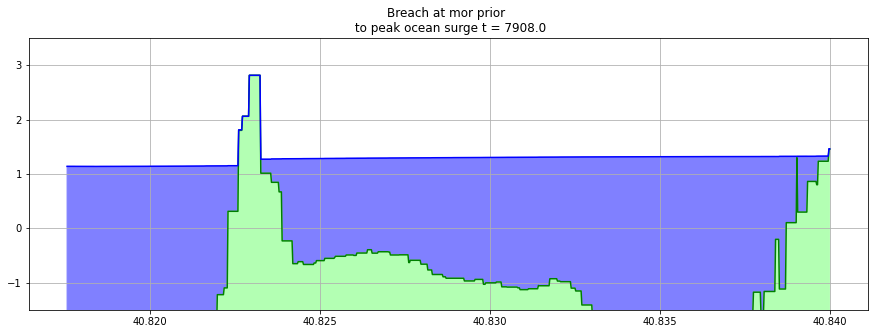

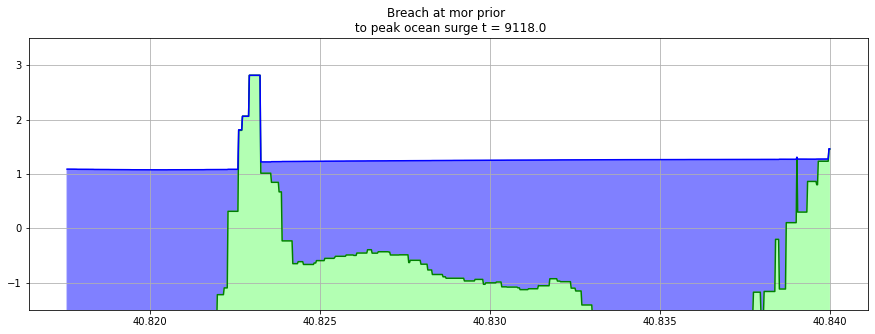

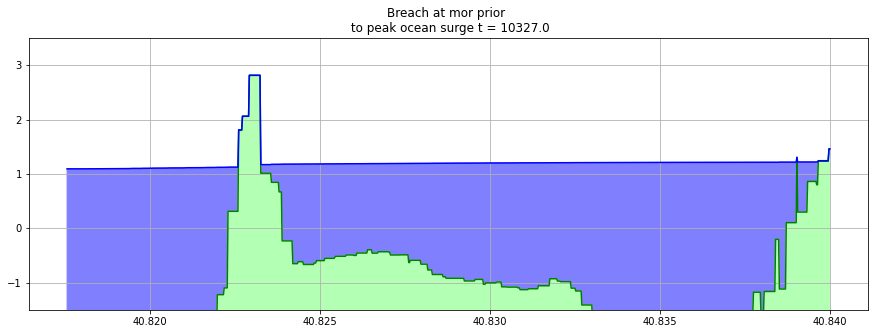

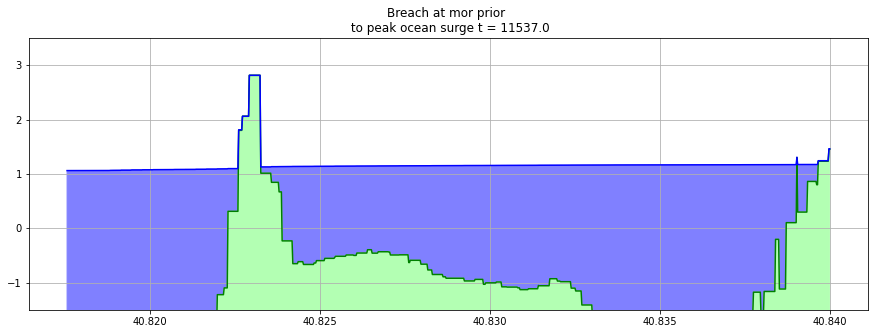

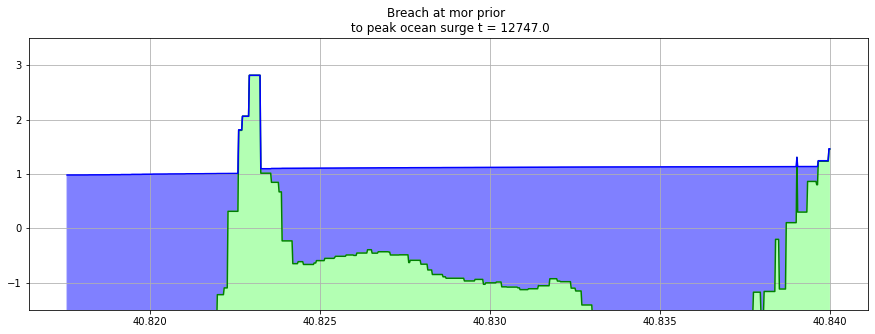

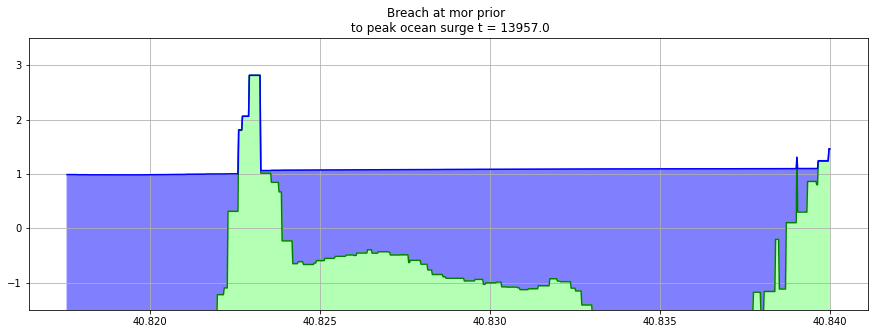

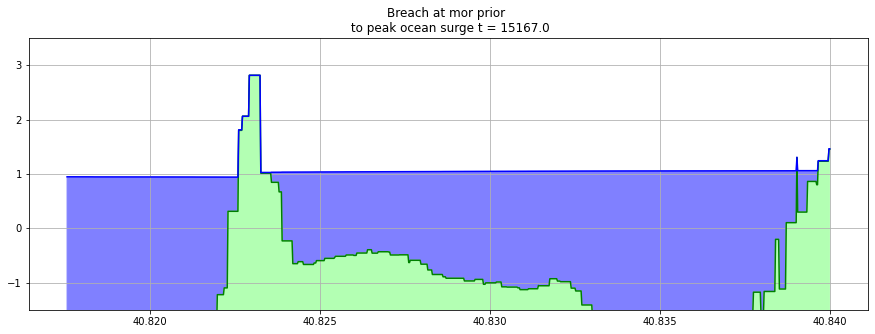

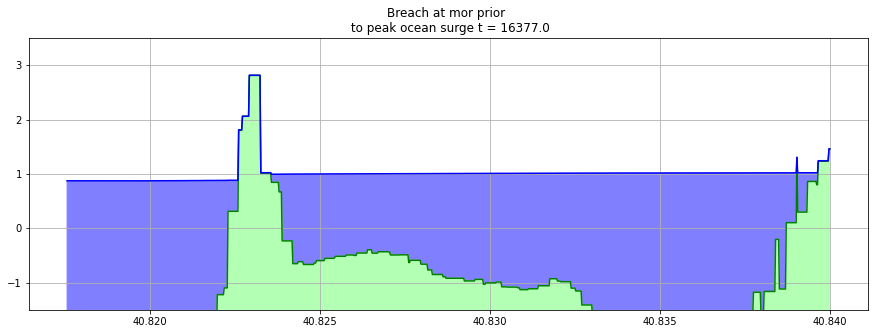

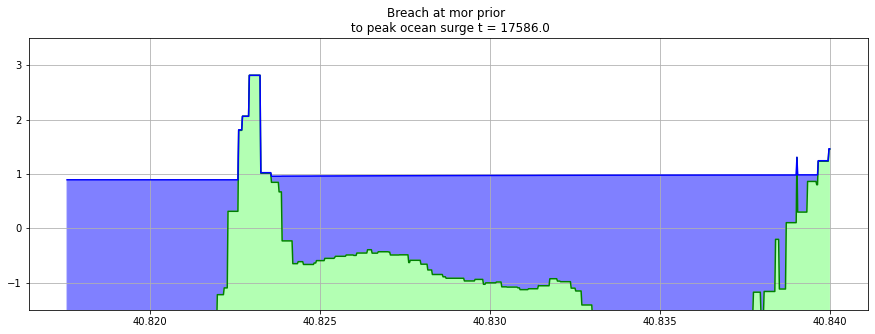

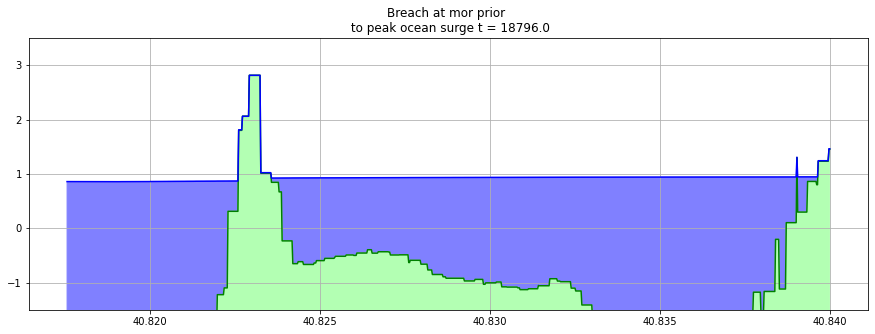

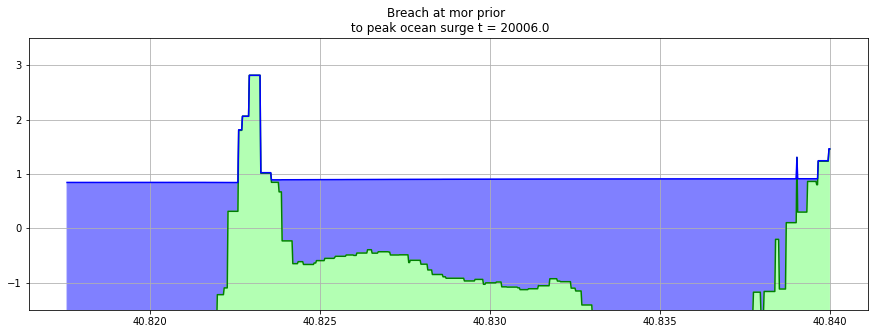

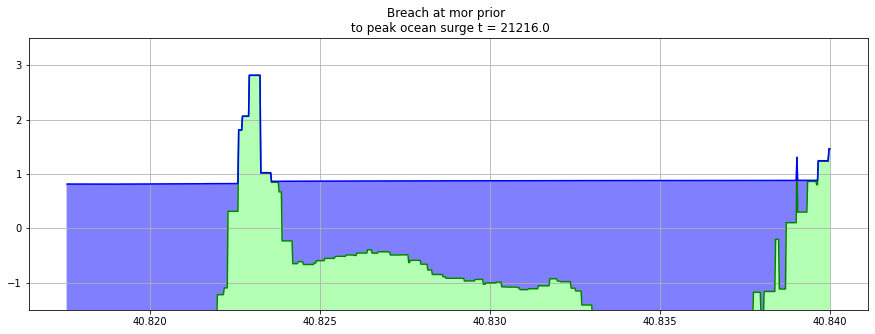

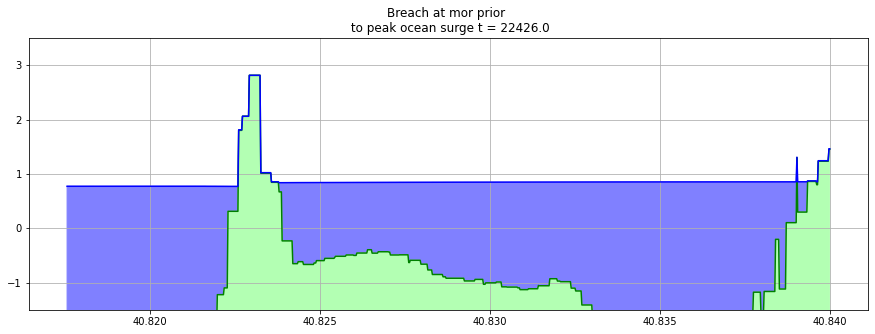

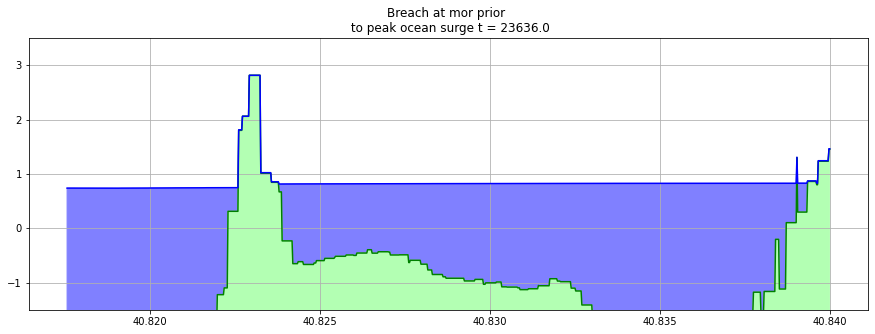

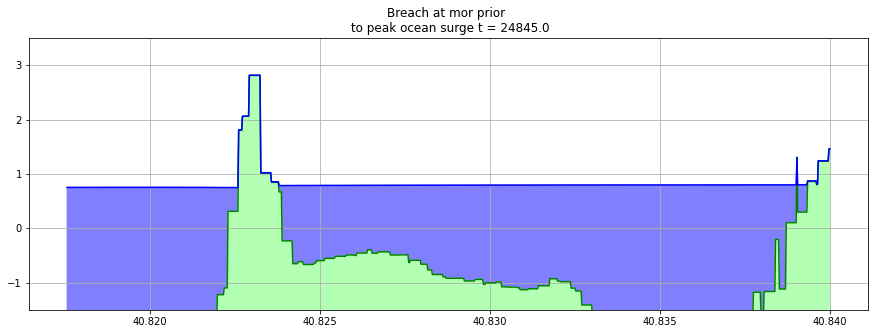

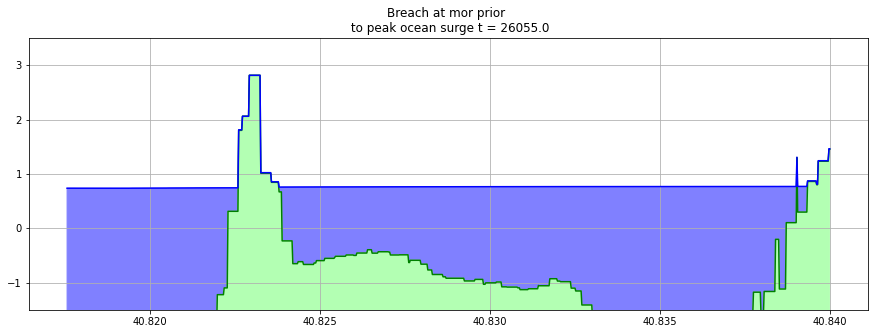

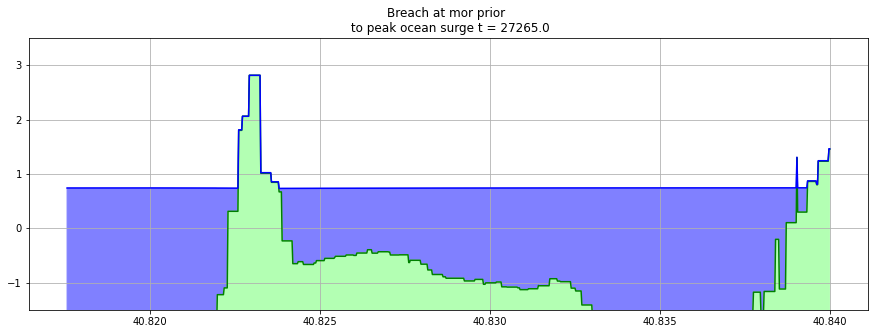

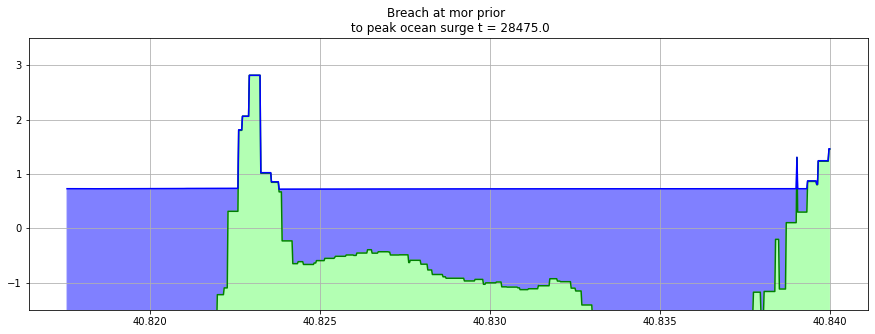

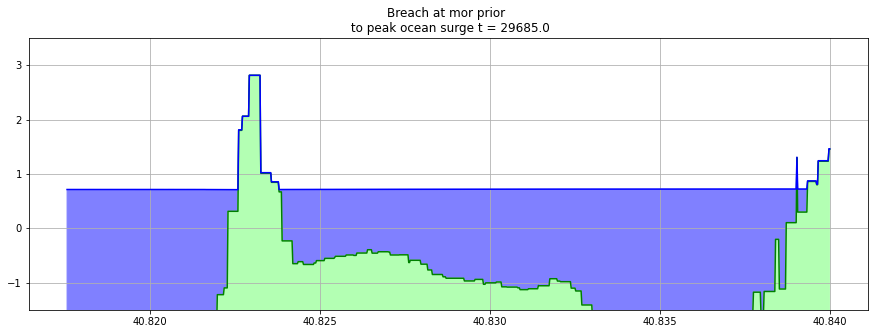

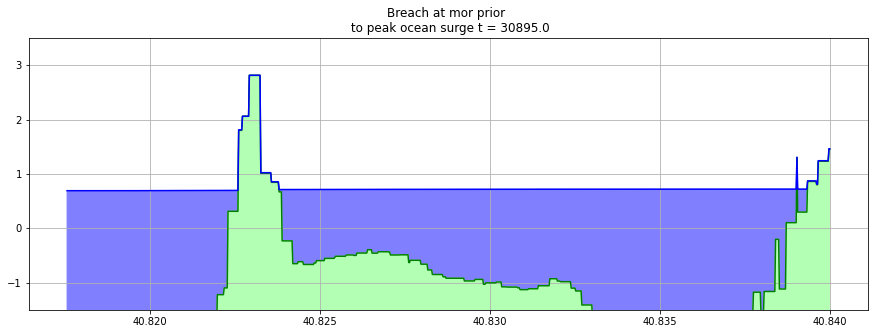

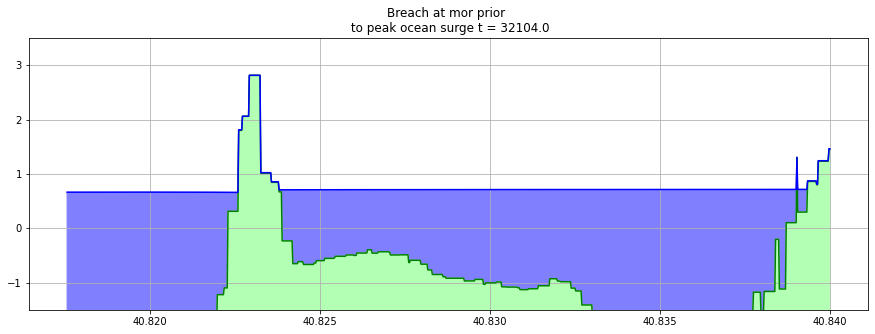

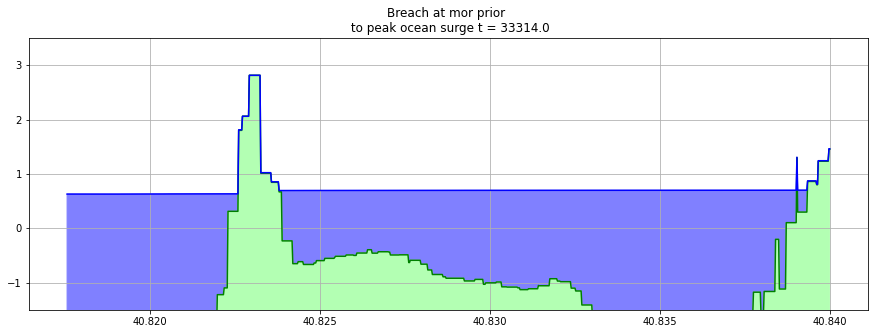

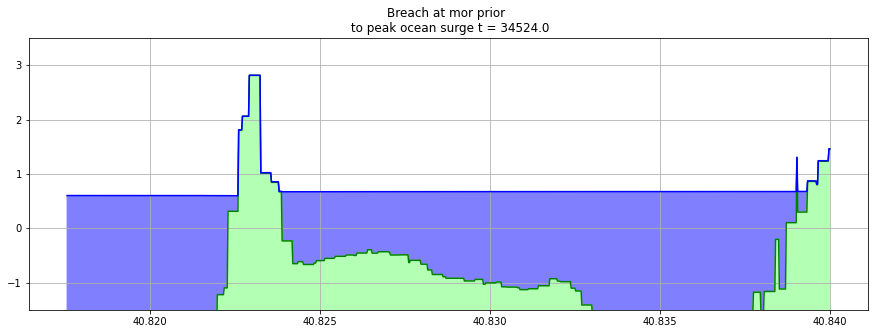

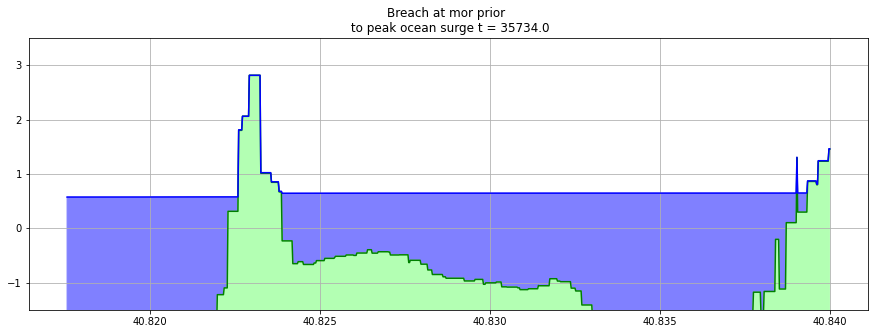

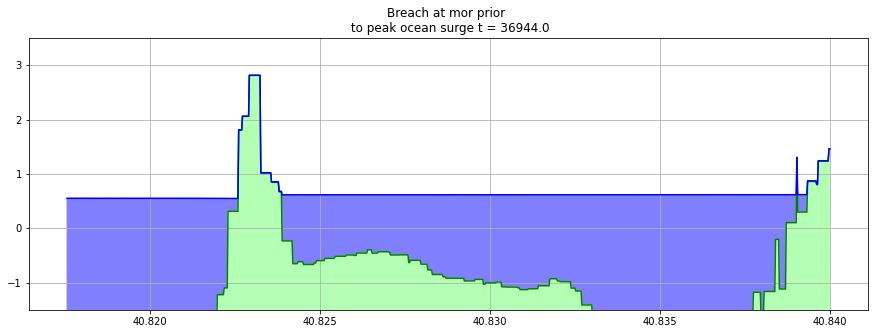

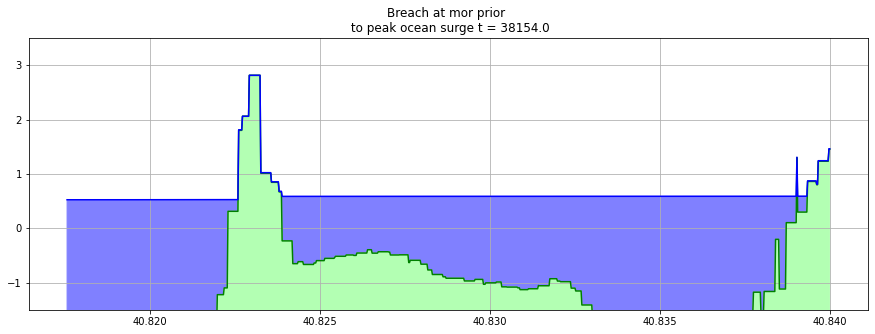

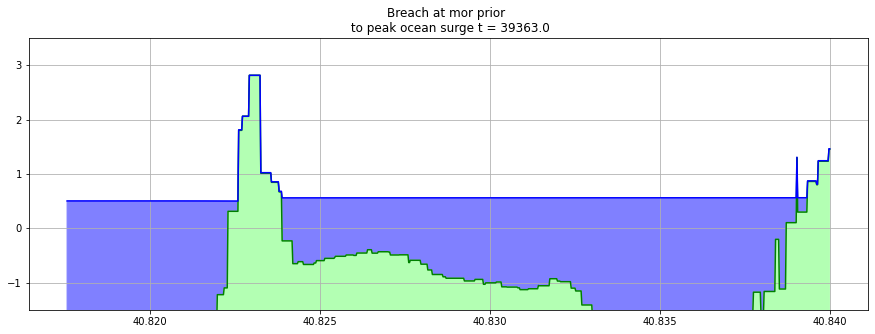

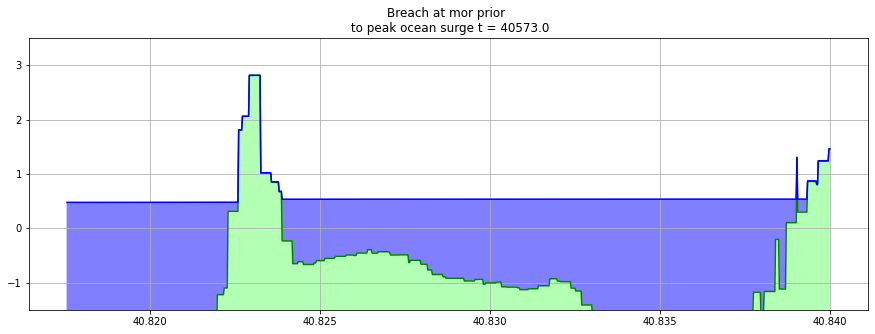

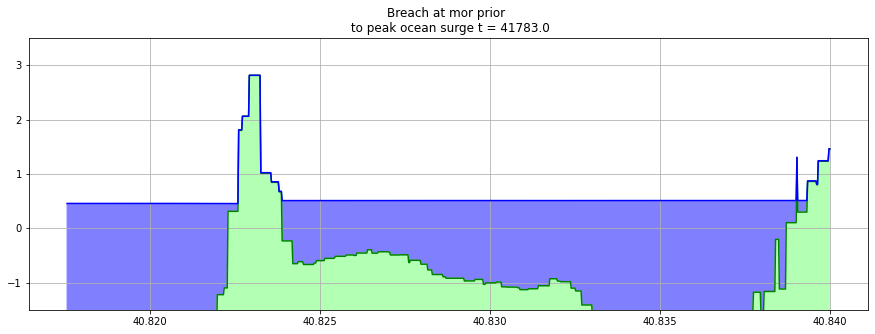

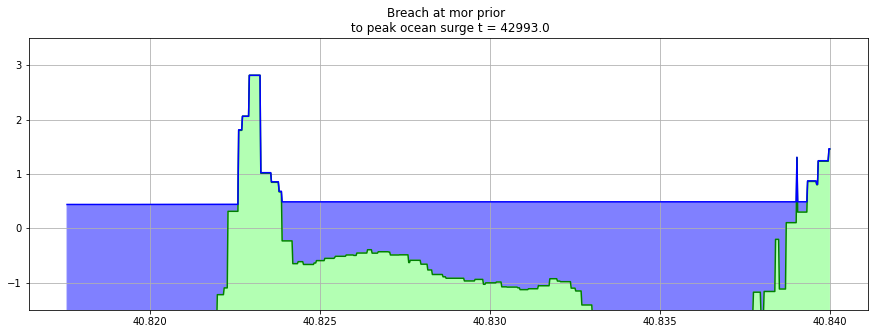

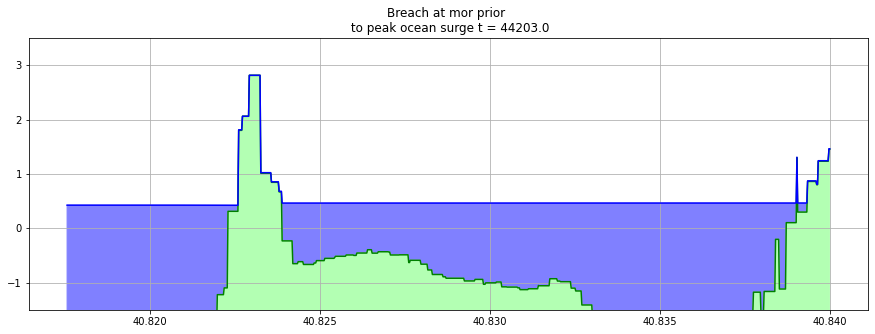

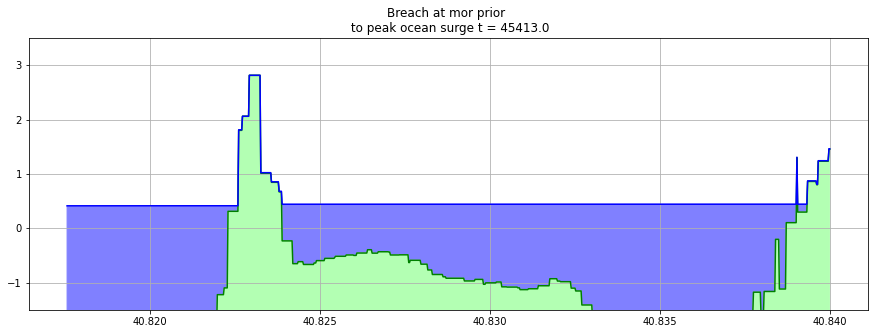

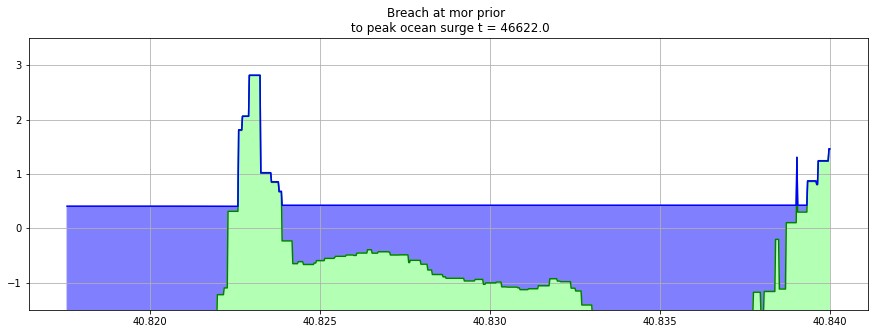

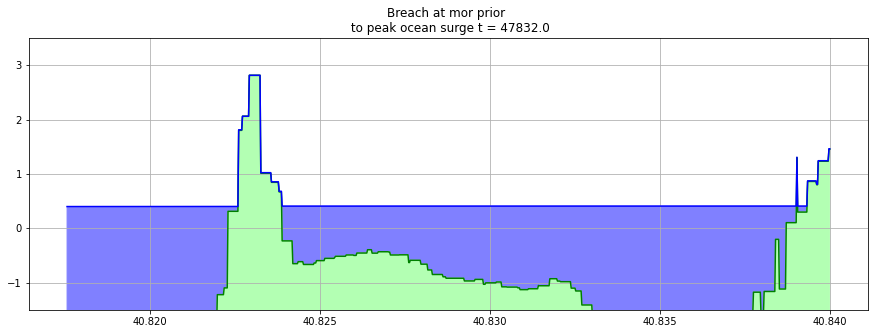

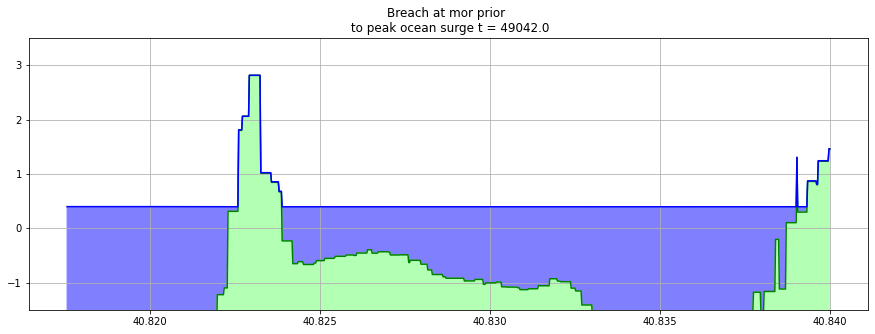

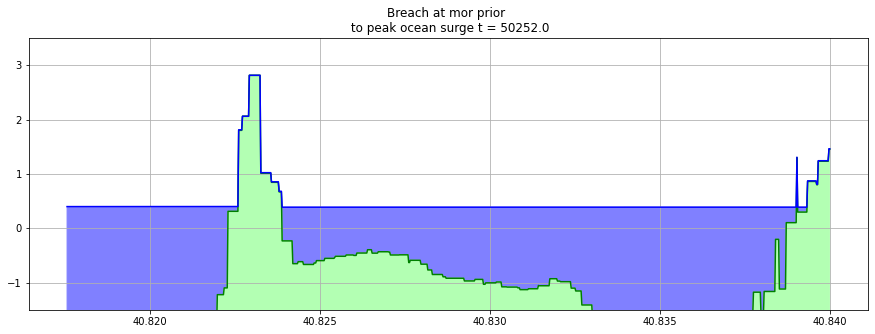

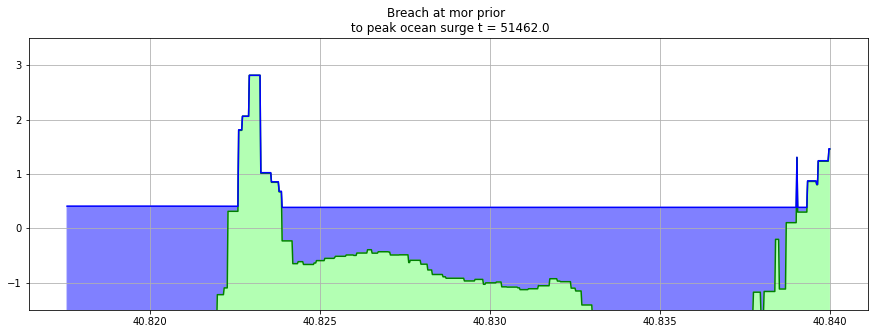

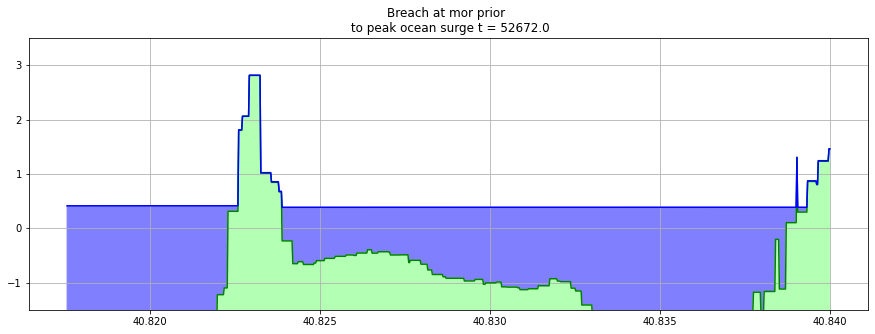

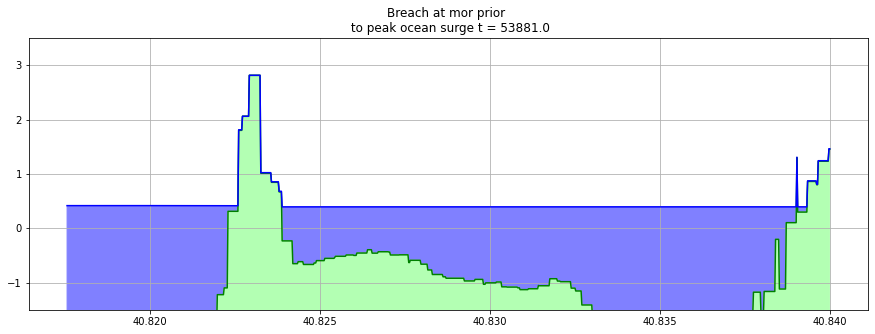

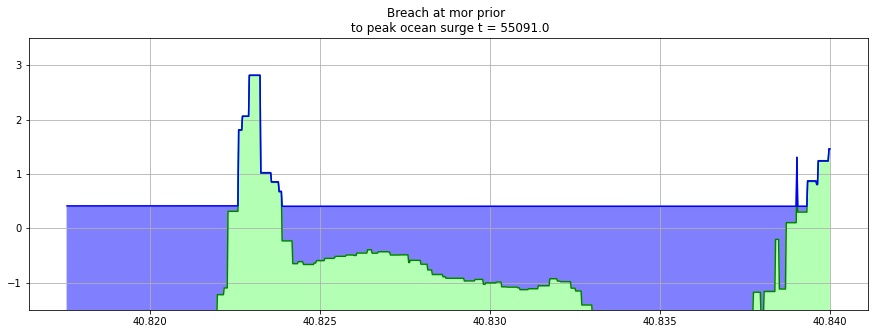

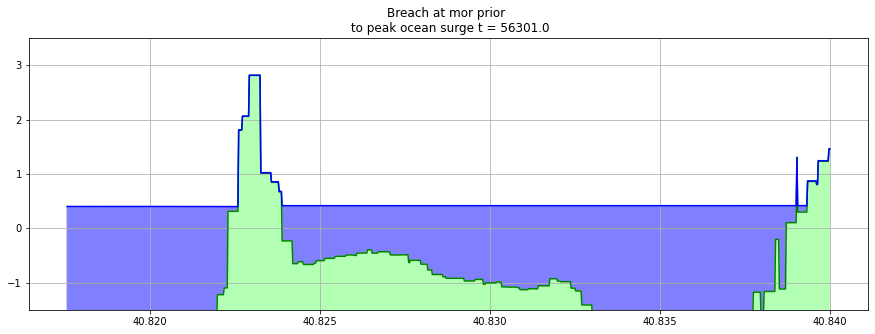

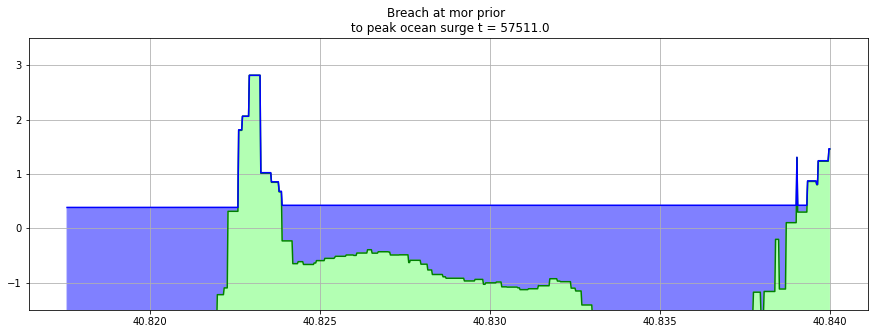

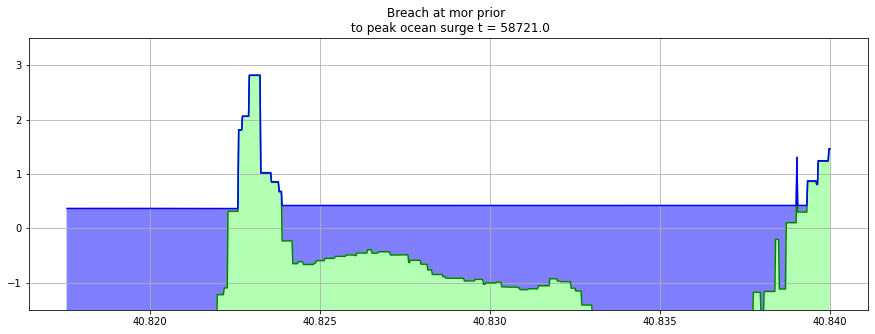

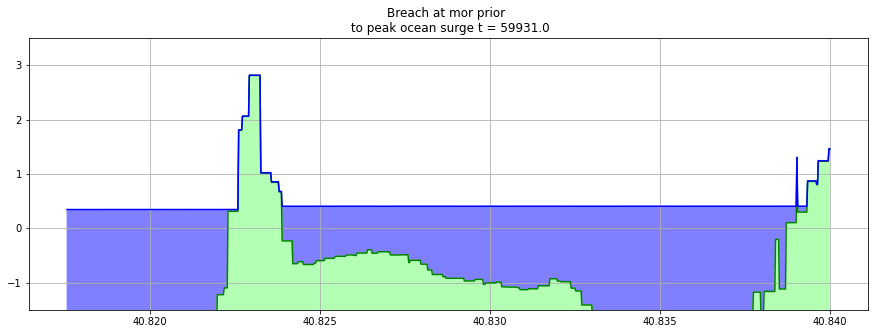

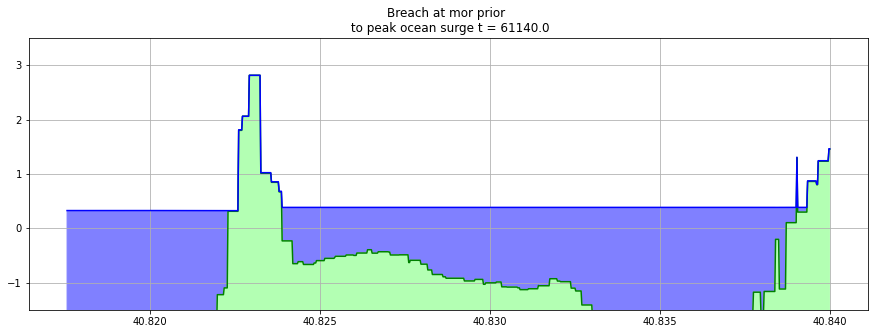

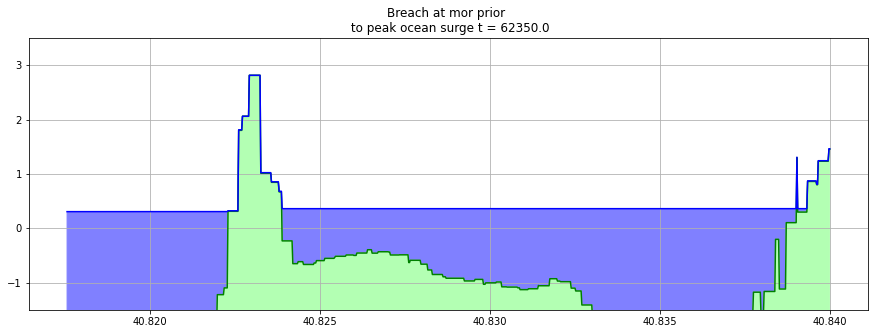

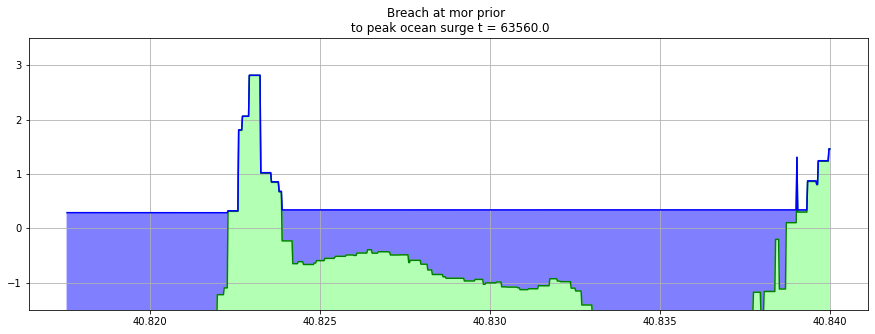

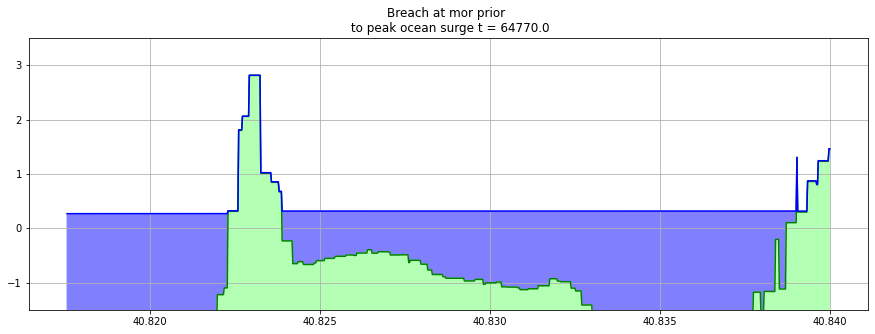

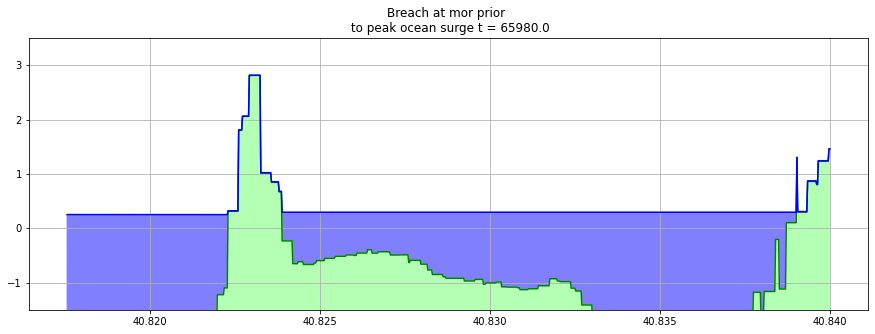

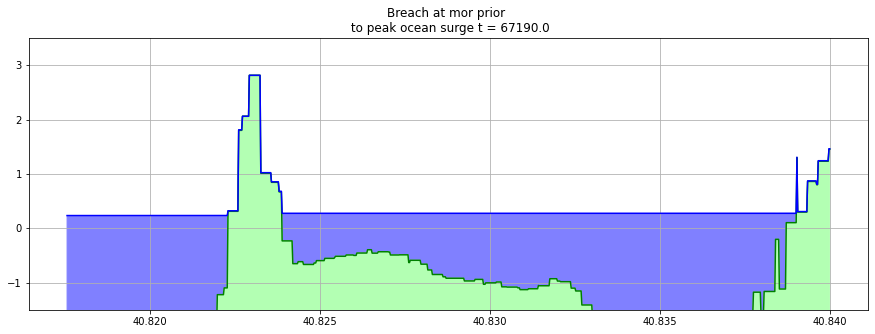

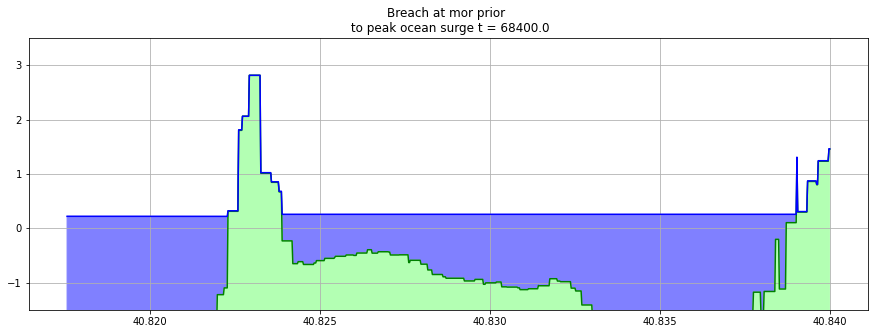

In [9]:
from clawpack.visclaw import gridtools
def plot_1d(yout, eta_out, B_out, axs, title, t):
    axs.fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs.fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs.plot(yout, B_out, 'g')
    axs.plot(yout, eta_out, c='b')
    axs.set_ylim(-1.5,3.5)
    axs.grid(which='major')
    axs.set_aspect(0.0016)
#     axs.xticks[-1.5,-.75, -.5, -.25, 0, .25, .5,.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5]
    axs.title.set_text(title + f' t = {t:.1f}')

for i in range(1,124):
    frameno = i
    SOURCE_PATH = '/Users/catherinej/RData/VT/gauss/'
    sims = ['mor']#, '6hrs', '4hrs', '2hrs', '0hrs']
    fig,axs = plt.subplots(nrows=1,ncols=len(sims), figsize=(25, 5), sharex=True, sharey=True)
    for idx, sim in enumerate(sims):
        framesoln = Solution(frameno, path=os.path.join(SOURCE_PATH, sim, '_output'),
                            file_format='binary') #VT/gauss/mor_10hrs/_output',
        eta = lambda q: q[3,:,:]
        B = lambda q: q[3,:,:] - q[0,:,:]

        out_var = lambda q: np.array((B(q), eta(q)))
        xlon = np.linspace(-72.552, -72.539, 1001)
        yout = np.linspace(40.840, 40.817553, 1001)
        xout = xlon #* np.ones(yout.shape)

        qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                       levels='all', return_ma=True)
        B_out = qout[0,:]
        eta_out = qout[1,:]
        t = framesoln.t
        title = f'Breach at {sim} prior \n to peak ocean surge'
        plot_1d(yout, eta_out, B_out, axs, title, t)
    fig.subplots_adjust(wspace=0.025)
    plt.savefig(f'/Users/catherinej/RData/VT/gauss/forced_wave/{i:03}.png')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/catherinej/Rdata/VT/gauss/b/30m/mor_24hrs/_output/fort.t0001'

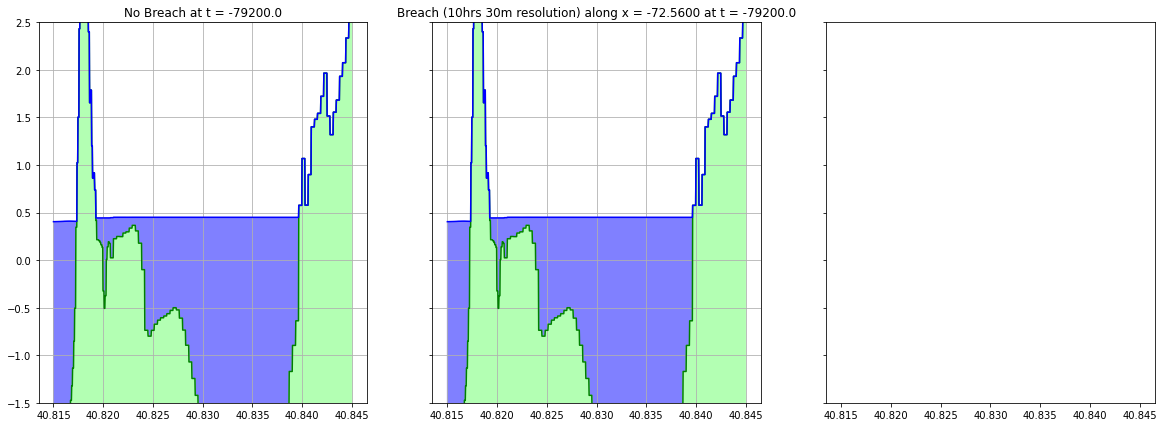

In [63]:
from clawpack.visclaw import gridtools
for i in range(1,124):
    frameno = i
    fig,axs = plt.subplots(nrows=1,ncols=3, figsize=(20,7), sharex=True, sharey=True)
    framesoln = Solution(frameno, path='/Users/catherinej/RData/VT/gauss/b/30m/mor/_output',
                        file_format='binary') #VT/gauss/mor_10hrs/_output',
    eta = lambda q: q[3,:,:]
    B = lambda q: q[3,:,:] - q[0,:,:]
    out_var = lambda q: np.array((B(q), eta(q)))
    xlon = -72.56
    yout = np.linspace(40.815, 40.845, 1001)
    xout = xlon * np.ones(yout.shape)

    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                   levels='all', return_ma=True)

    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[0].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs[0].fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs[0].plot(yout, B_out, 'g')
    axs[0].plot(yout, eta_out, 'b')
    axs[0].set_ylim(-1.5,2.5)
    axs[0].grid(which='major')
    
#     plt.show()
    axs[0].title.set_text('No Breach at t = %.1f' % (framesoln.t))

#     ax2 = plt.subplot(122)
    framesoln = Solution(frameno, path='/Users/catherinej/Rdata/VT/gauss/b/30m/mor_10hrs/_output',
                         file_format='binary') # VT/gauss/no_breach/mor/_output
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[1].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs[1].fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs[1].plot(yout, B_out, 'g')
    axs[1].plot(yout, eta_out, 'b')
    axs[1].set_ylim(-1.5,2.5)
    axs[1].title.set_text('Breach (10hrs 30m resolution) along x = %.4f at t = %.1f' % (xlon, framesoln.t))
    axs[1].grid()
    
    
    framesoln = Solution(frameno, path='/Users/catherinej/Rdata/VT/gauss/b/30m/mor_24hrs/_output',
                         file_format='binary') # VT/gauss/no_breach/mor/_output
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[2].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs[2].fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs[2].plot(yout, B_out, 'g')
    axs[2].plot(yout, eta_out, 'b')
    axs[2].set_ylim(-1.5,2.5)
    axs[2].title.set_text('Breach (24hrs) along x = %.4f at t = %.1f' % (xlon, framesoln.t))
    axs[2].grid()
    fig.subplots_adjust(wspace=0.05)
#     plt.grid()
    plt.savefig(f'times/{frameno:03}.png')
    plt.show()

In [6]:
from clawpack.visclaw import gridtools

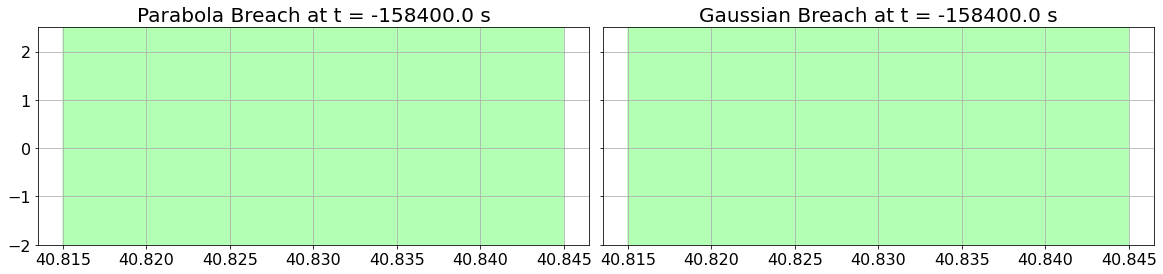

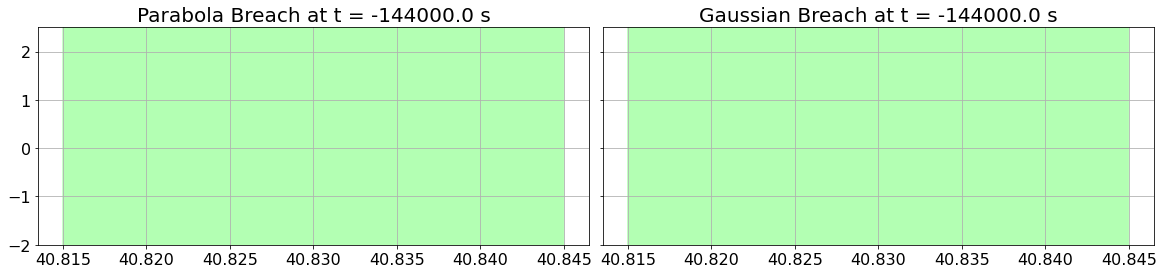

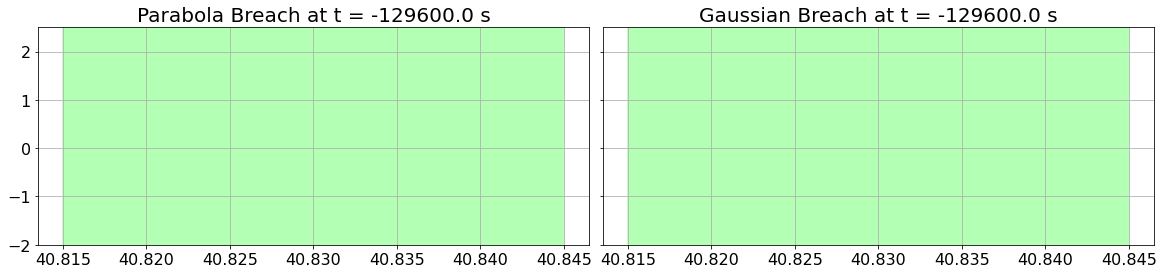

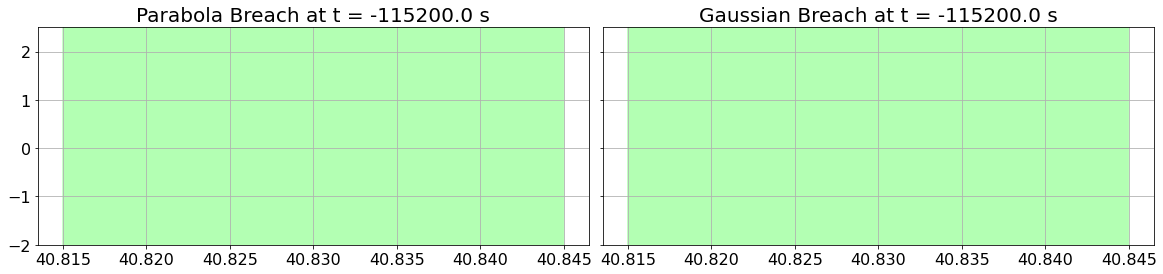

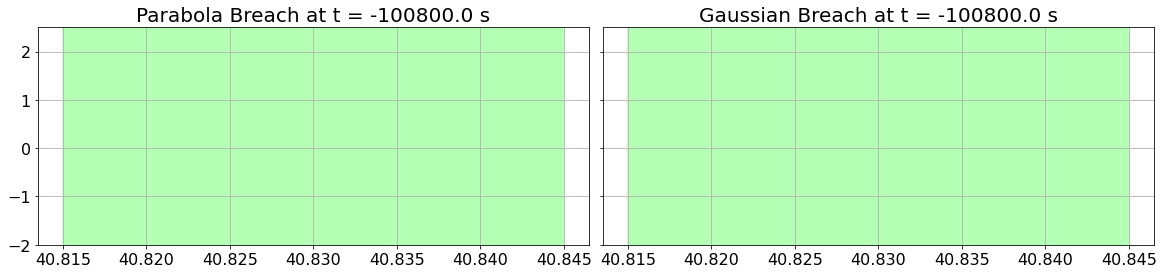

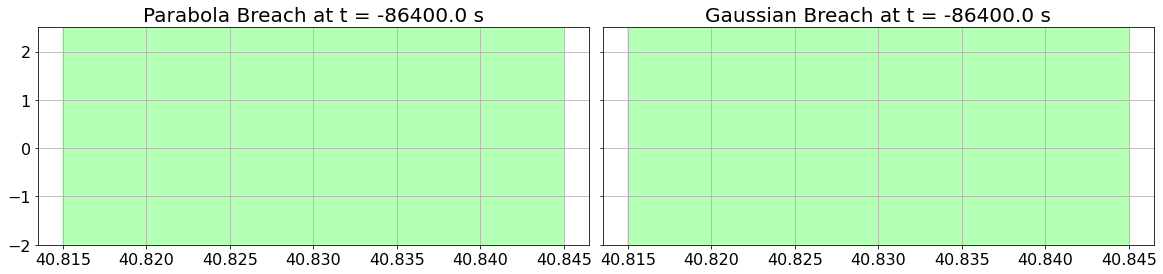

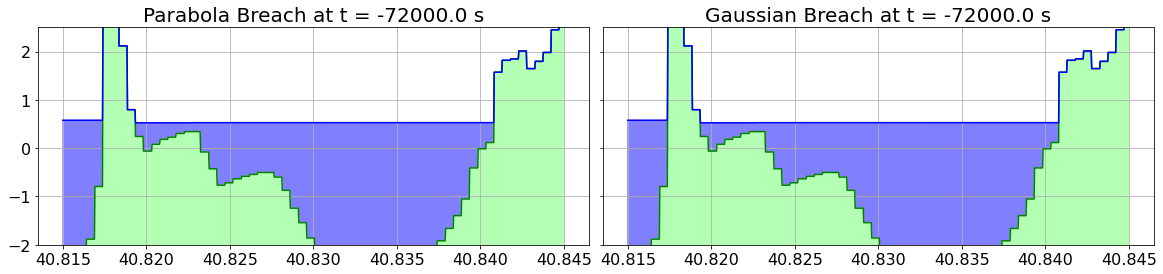

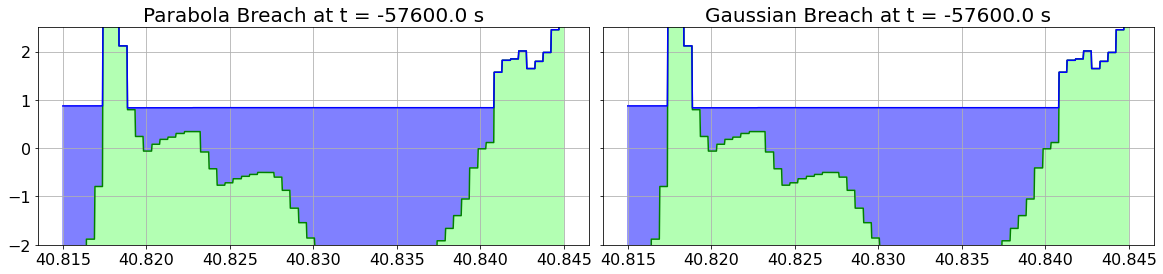

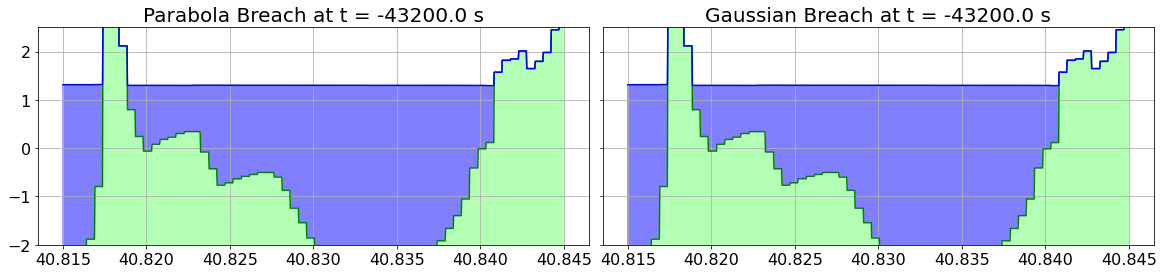

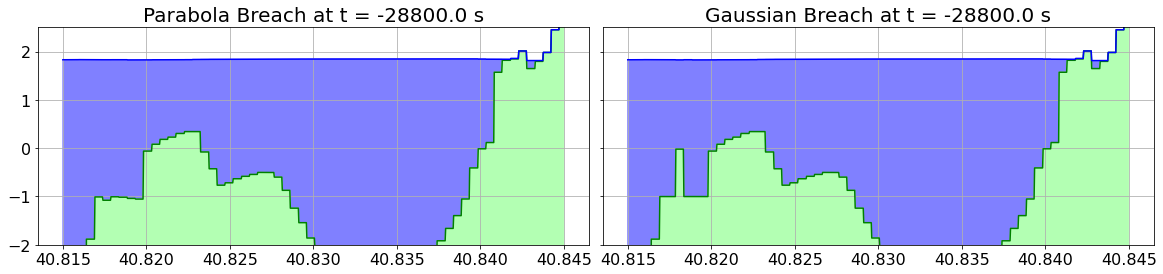

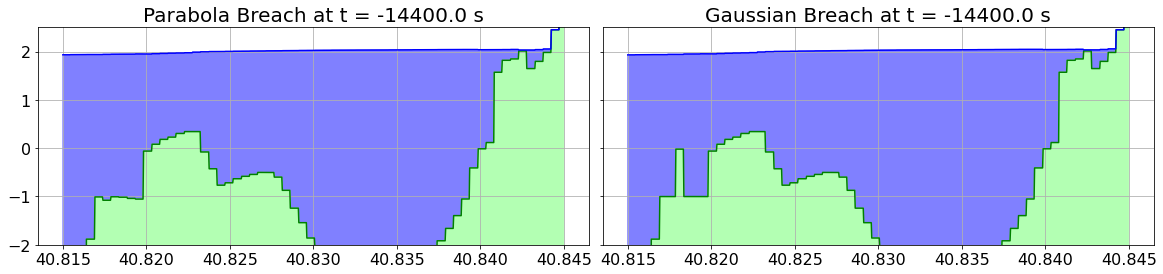

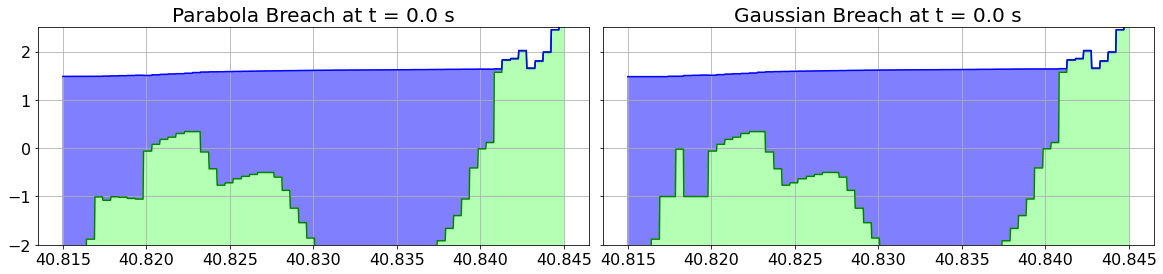

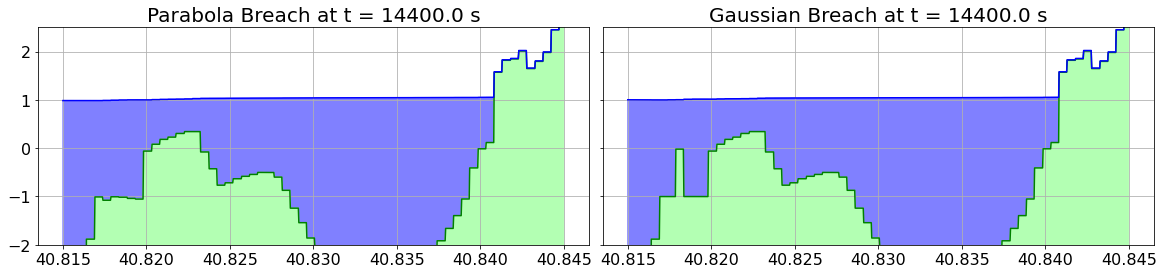

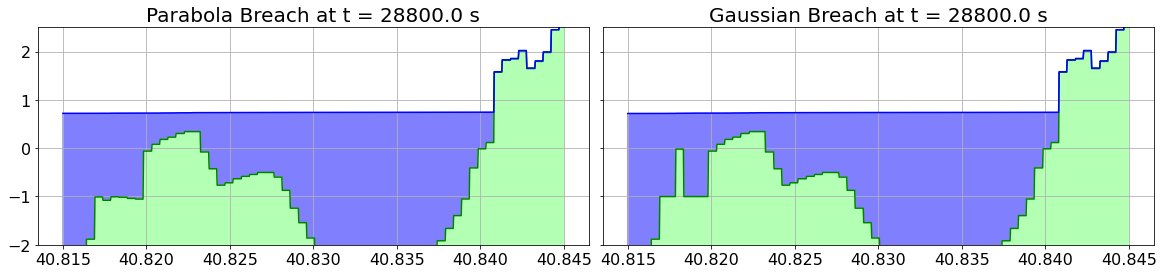

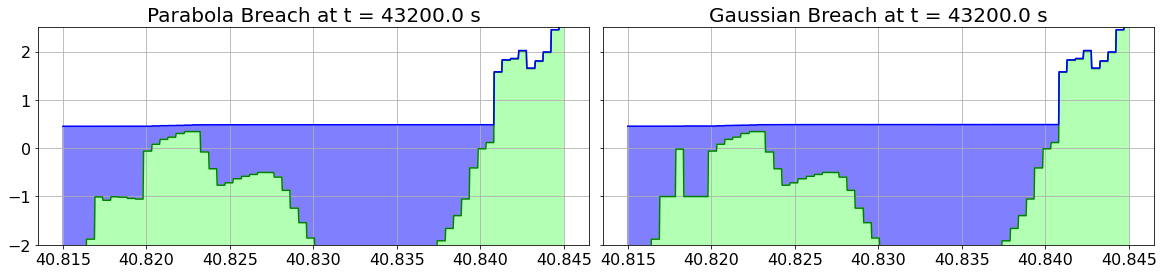

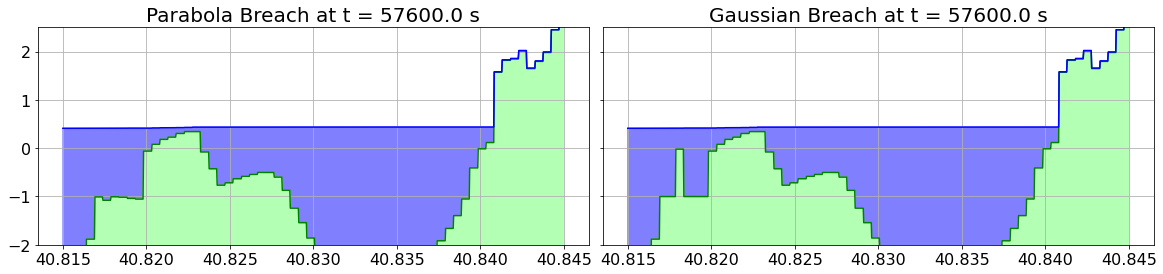

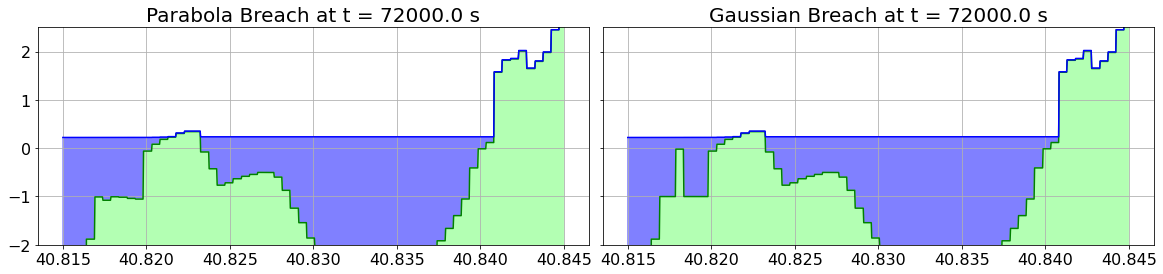

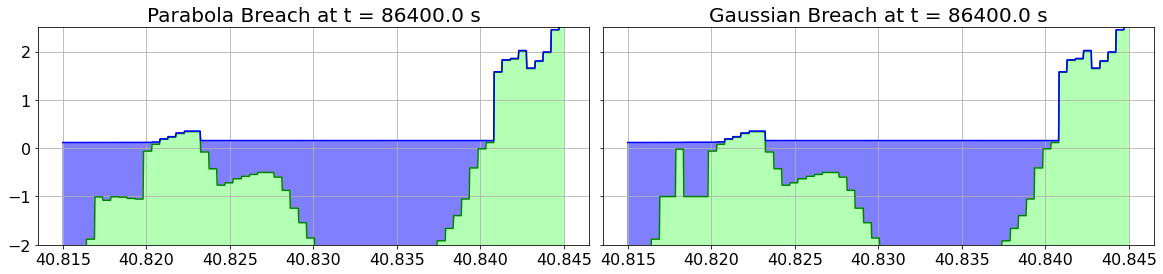

In [9]:
for i in range(1,19):
    frameno = i
    fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(20,4), sharex=True, sharey=True)
    framesoln = Solution(frameno, path='/Users/catherinej/Desktop/mor_2breaches_parabola/_output',
                        file_format='ascii') #VT/gauss/mor_10hrs/_output',
    eta = lambda q: q[3,:,:]
    B = lambda q: q[3,:,:] - q[0,:,:]
    out_var = lambda q: np.array((B(q), eta(q)))
    xlon = -72.56
    yout = np.linspace(40.815, 40.845, 1001)
    xout = xlon * np.ones(yout.shape)

    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                   levels='all', return_ma=True)

    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[0].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs[0].fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs[0].plot(yout, B_out, 'g')
    axs[0].plot(yout, eta_out, 'b')
    axs[0].set_ylim(-2,2)
    axs[0].grid(which='major')
    
#     plt.show()
    axs[0].set_title('Parabola Breach at t = %.1f s' % (framesoln.t), fontsize=20)
    axs[0].tick_params(axis='both',labelsize=16)

#     ax2 = plt.subplot(122)
    framesoln = Solution(frameno, path='/Users/catherinej/Desktop/mor_2breaches_gaussian/_output',
                         file_format='ascii') # VT/gauss/no_breach/mor/_output
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[1].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
    axs[1].fill_between(yout, B_out, -6, color=[.7,1,.7])
    axs[1].plot(yout, B_out, 'g')
    axs[1].plot(yout, eta_out, 'b')
    axs[1].set_ylim(-2,2.5)
    axs[1].set_title('Gaussian Breach at t = %.1f s' % (framesoln.t), fontsize=20)
    axs[1].grid()
    axs[1].tick_params(axis='both',labelsize=16)
    
    
#     framesoln = Solution(frameno, path='/Users/catherinej/Rdata/VT/gauss/b/30m/mor_24hrs/_output',
#                          file_format='binary') # VT/gauss/no_breach/mor/_output
#     qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
#                                      levels='all',return_ma=True)
#     B_out = qout[0,:]
#     eta_out = qout[1,:]

#     axs[2].fill_between(yout, eta_out, B_out, color=[.5,.5,1])
#     axs[2].fill_between(yout, B_out, -6, color=[.7,1,.7])
#     axs[2].plot(yout, B_out, 'g')
#     axs[2].plot(yout, eta_out, 'b')
#     axs[2].set_ylim(-2,2)
#     axs[2].title.set_text('Breach (24hrs) along x = %.4f at t = %.1f' % (xlon, framesoln.t))
#     axs[2].grid()
    fig.subplots_adjust(wspace=0.025)
# #     plt.grid()
    plt.savefig(f'{frameno:03}.png', dpi=250, bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

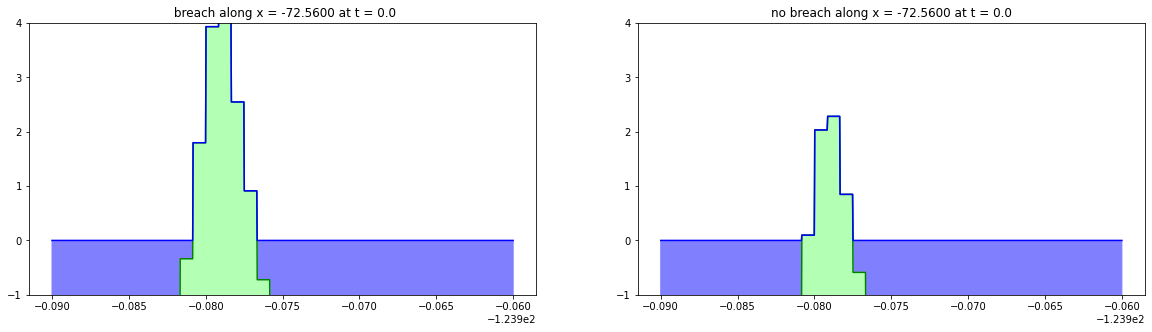

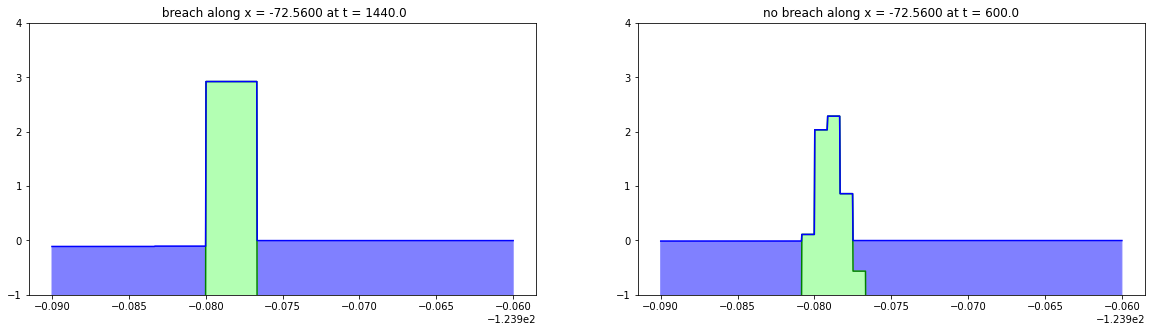

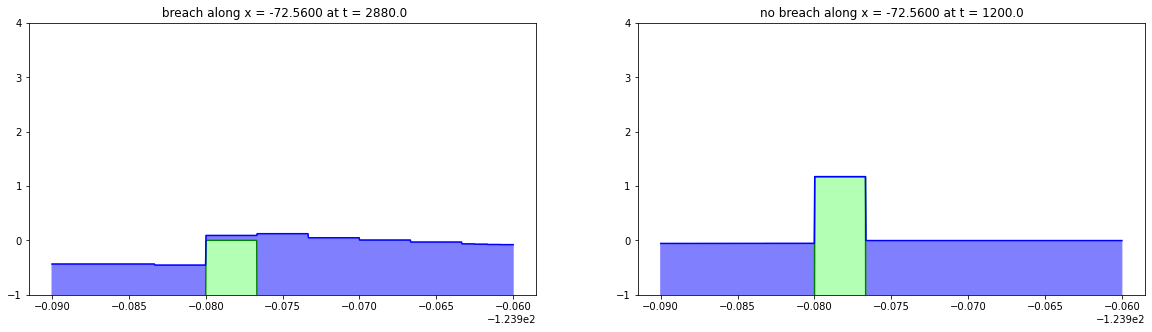

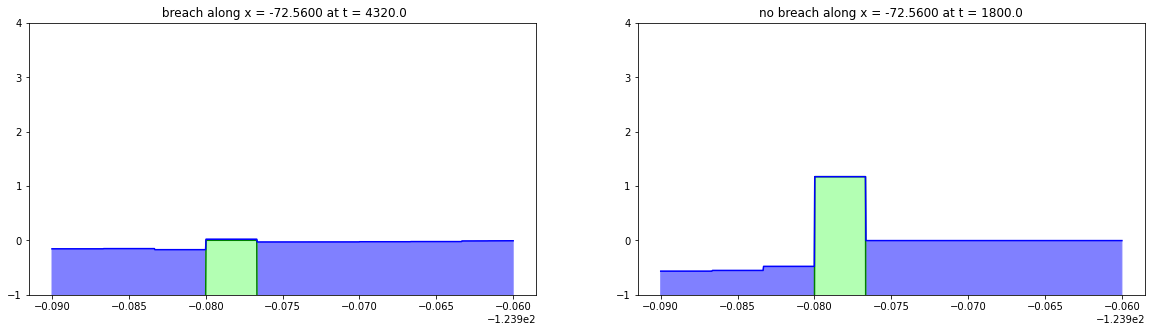

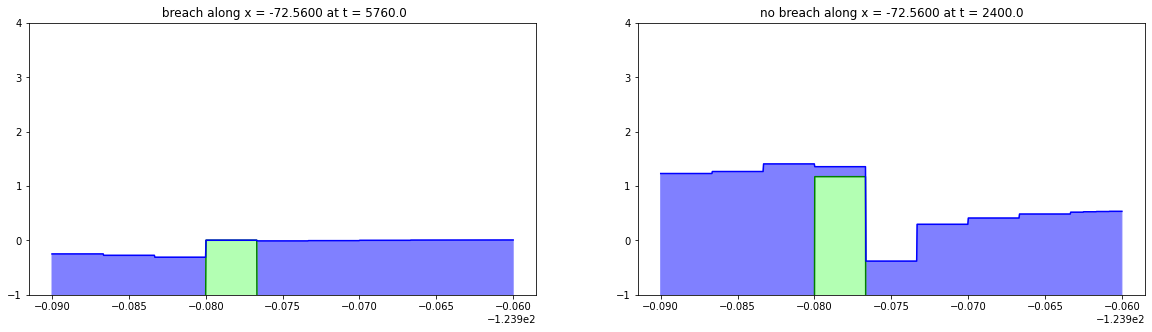

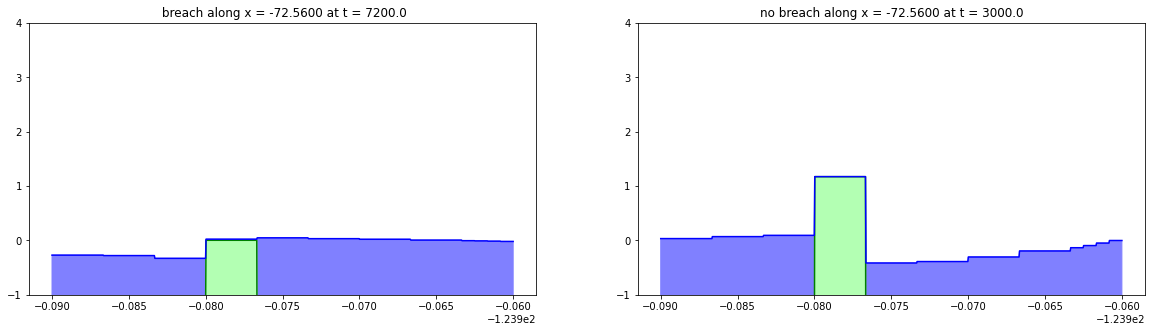

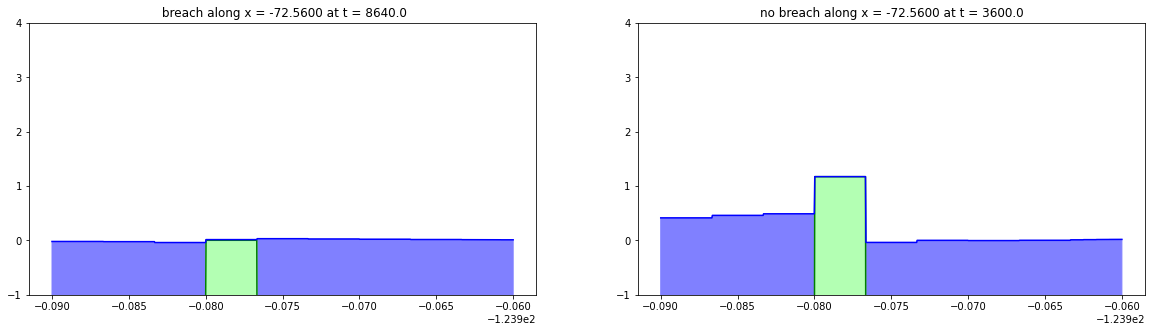

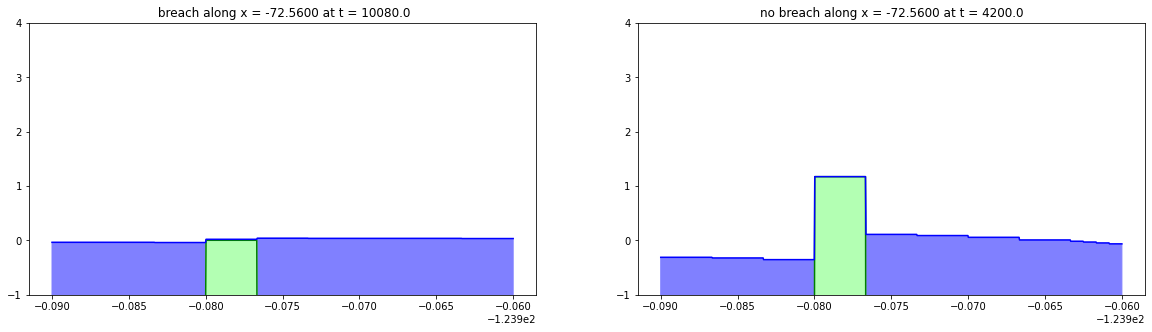

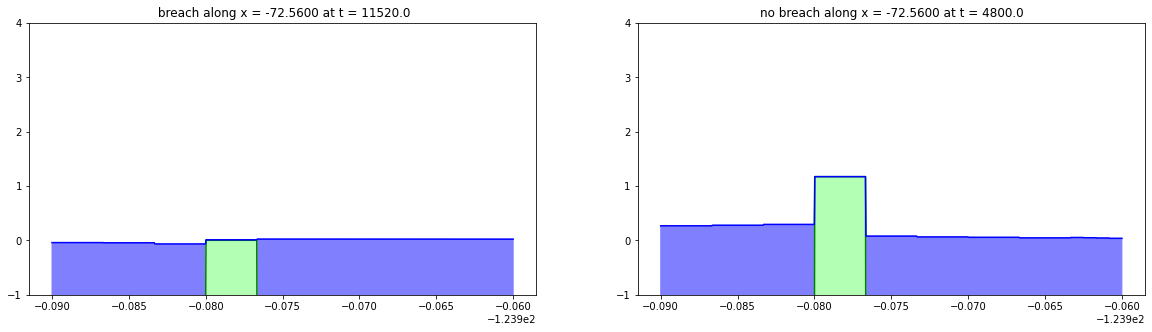

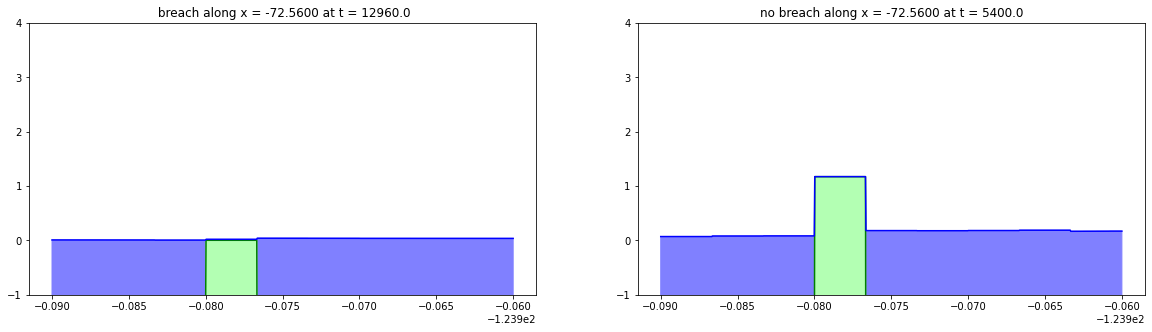

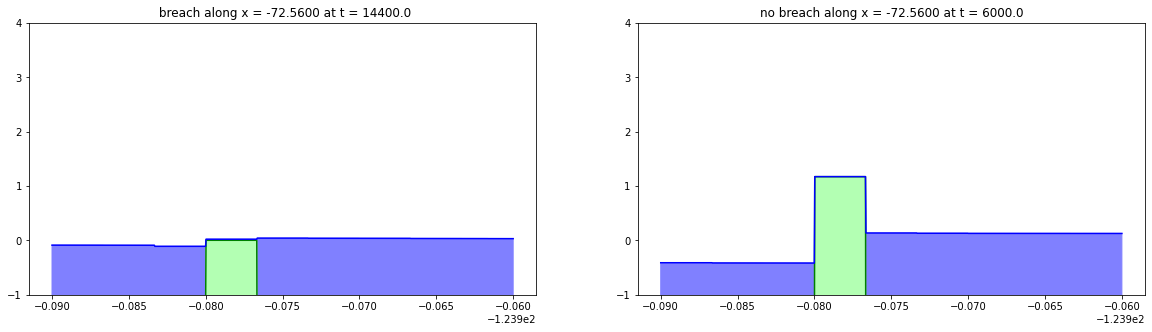

In [165]:
from clawpack.visclaw import gridtools
for i in range(0,11):
    frameno = i
    fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
    framesoln = Solution(frameno, path='/Users/catherinej/RData/seaside/b_3m/_output',
                        file_format='ascii') #VT/gauss/mor_10hrs/_output',
    eta = lambda q: q[3,:,:]
    B = lambda q: q[3,:,:] - q[0,:,:]
    out_var = lambda q: np.array((B(q), eta(q)))
    ylat = 46.11
    xout = np.linspace(-123.99, -123.96, 1001)
    yout = ylat * np.ones(xout.shape)

    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                   levels='all', return_ma=True)

    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[0].fill_between(xout, eta_out, B_out, color=[.5,.5,1])
    axs[0].fill_between(xout, B_out, -6, color=[.7,1,.7])
    axs[0].plot(xout, B_out, 'g')
    axs[0].plot(xout, eta_out, 'b')
    axs[0].set_ylim(-1,4)
    
#     plt.show()
    axs[0].title.set_text(' breach along x = %.4f at t = %.1f' % (xlon, framesoln.t))

#     ax2 = plt.subplot(122)
    framesoln = Solution(frameno, path='/Users/catherinej/Rdata/seaside/no_b3m/_output',
                         file_format='ascii') # VT/gauss/no_breach/mor/_output
    qout = gridtools.grid_output_2d(framesoln, out_var, xout, yout, 
                                     levels='all',return_ma=True)
    B_out = qout[0,:]
    eta_out = qout[1,:]

    axs[1].fill_between(xout, eta_out, B_out, color=[.5,.5,1])
    axs[1].fill_between(xout, B_out, -6, color=[.7,1,.7])
    axs[1].plot(xout, B_out, 'g')
    axs[1].plot(xout, eta_out, 'b')
    axs[1].set_ylim(-1,4)
    axs[1].title.set_text('no breach along x = %.4f at t = %.1f' % (xlon, framesoln.t))
    plt.savefig(f'{frameno}.png')
    plt.show()